In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn_extra.cluster import KMedoids  # PAM


import warnings

warnings.filterwarnings("ignore")

encoder = OrdinalEncoder()
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering


sns.set(font_scale=1.5)
sns.set_style("darkgrid")
sns.set_palette("pastel")
plt.rcParams["figure.figsize"] = [15, 7]

In [211]:
data = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
data = data.drop(columns="customerID")
data.drop_duplicates(inplace=True)
data.drop("TotalCharges", axis=1, inplace=True)


scaler = StandardScaler()
data[["tenure", "MonthlyCharges"]] = scaler.fit_transform(
    data[["tenure", "MonthlyCharges"]]
)

# DF cluster - DF z oryginalnymi danymi
df_cluster = data.copy()


# df_cluster[
#     df_cluster.columns[~df_cluster.columns.isin(["tenure", "MonthlyCharges"])]
# ] = encoder.fit_transform(
#     df_cluster[
#         df_cluster.columns[~df_cluster.columns.isin(["tenure", "MonthlyCharges"])]
#     ]
# )

nominal_features = ("PaperlessBilling", "Dependents", "Partner", "Churn", 'PhoneService')
for feature in nominal_features:
    data[feature] = data[feature].map({"Yes": 1, "No": 0})
    
# Dane ilościowe
data = pd.get_dummies(
    data,
    columns=[
        "InternetService",
        "OnlineSecurity",
        "MultipleLines",
        "OnlineBackup",
        "DeviceProtection",
        "TechSupport",
        "StreamingTV",
        "StreamingMovies",
        "Contract",
        "PaymentMethod",
    ],
)
data.gender = data.gender.map({"Female": 1, "Male": 0})
# # No internet service column has the same values (we checked it before) for OnlineSecurity, OnlineBackup, DeviceProtection,
# # TechSupport, StreamingTV and StreamingMovies

data.drop(
    columns=[
        "OnlineSecurity_No internet service",
        "OnlineBackup_No internet service",
        "DeviceProtection_No internet service",
        "TechSupport_No internet service",
        "StreamingTV_No internet service",
        "StreamingMovies_No internet service",
    ],
    inplace=True,
)

# take data without churn columns:
y = data.Churn
df_cluster.drop(columns='Churn', inplace=True)
data.drop(columns='Churn', inplace=True)


In [213]:
y

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7021, dtype: int64

In [185]:
set(data.PhoneService)

{'No', 'Yes'}

In [215]:
data

gender  SeniorCitizen  Partner  Dependents    tenure  PhoneService  \
0          1              0        1           0 -1.282728             0   
1          0              0        0           0  0.062387             1   
2          0              0        0           0 -1.241967             1   
3          0              0        0           0  0.510759             0   
4          1              0        0           0 -1.241967             1   
...      ...            ...      ...         ...       ...           ...   
7038       0              0        1           1 -0.345224             1   
7039       1              0        1           1  1.611307             1   
7040       1              0        1           1 -0.875118             0   
7041       0              1        1           0 -1.160445             1   
7042       0              0        0           0  1.366741             1   

      PaperlessBilling  MonthlyCharges  InternetService_DSL  \
0                    1       -1.164135                    1   
1                    0       -0.262811                    1   
2                    1       -0.365914                    1   
3                    0       -0.750058                    1   
4                    1        0.194503                    0   
...                ...             ...                  ...   
7038                 1        0.663458                    1   
7039                 1        1.275428                    0   
7040                 1       -1.172450                    1   
7041                 1        0.317562                    0   
7042                 1        1.356913                    0   

      InternetService_Fiber optic  ...  StreamingTV_Yes  StreamingMovies_No  \
0                               0  ...                0                   1   
1                               0  ...                0                   1   
2                               0  ...                0                   1   
3                               0  ...                0                   1   
4                               1  ...                0                   1   
...                           ...  ...              ...                 ...   
7038                            0  ...                1                   0   
7039                            1  ...                1                   0   
7040                            0  ...                0                   1   
7041                            1  ...                0                   1   
7042                            1  ...                1                   0   

      StreamingMovies_Yes  Contract_Month-to-month  Contract_One year  \
0                       0                        1                  0   
1                       0                        0                  1   
2                       0                        1                  0   
3                       0                        0                  1   
4                       0                        1                  0   
...                   ...                      ...                ...   
7038                    1                        0                  1   
7039                    1                        0                  1   
7040                    0                        1                  0   
7041                    0                        1                  0   
7042                    1                        0                  0   

      Contract_Two year  PaymentMethod_Bank transfer (automatic)  \
0                     0                                        0   
1                     0                                        0   
2                     0                                        0   
3                     0                                        1   
4                     0                                        0   
...                 ...                                      ...   
7038                  0           

In [217]:
df_cluster

gender  SeniorCitizen Partner Dependents    tenure PhoneService  \
0     Female              0     Yes         No -1.282728           No   
1       Male              0      No         No  0.062387          Yes   
2       Male              0      No         No -1.241967          Yes   
3       Male              0      No         No  0.510759           No   
4     Female              0      No         No -1.241967          Yes   
...      ...            ...     ...        ...       ...          ...   
7038    Male              0     Yes        Yes -0.345224          Yes   
7039  Female              0     Yes        Yes  1.611307          Yes   
7040  Female              0     Yes        Yes -0.875118           No   
7041    Male              1     Yes         No -1.160445          Yes   
7042    Male              0      No         No  1.366741          Yes   

         MultipleLines InternetService OnlineSecurity OnlineBackup  \
0     No phone service             DSL             No          Yes   
1                   No             DSL            Yes           No   
2                   No             DSL            Yes          Yes   
3     No phone service             DSL            Yes           No   
4                   No     Fiber optic             No           No   
...                ...             ...            ...          ...   
7038               Yes             DSL            Yes           No   
7039               Yes     Fiber optic             No          Yes   
7040  No phone service             DSL            Yes           No   
7041               Yes     Fiber optic             No           No   
7042                No     Fiber optic            Yes           No   

     DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0                  No          No          No              No  Month-to-month   
1                 Yes          No          No              No        One year   
2                  No          No          No              No  Month-to-month   
3                 Yes         Yes          No              No        One year   
4                  No          No          No              No  Month-to-month   
...               ...         ...         ...             ...             ...   
7038              Yes         Yes         Yes             Yes        One year   
7039              Yes          No         Yes             Yes        One year   
7040               No          No          No              No  Month-to-month   
7041               No          No          No              No  Month-to-month   
7042              Yes         Yes         Yes             Yes        Two year   

     PaperlessBilling              PaymentMethod  MonthlyCharges  
0                 Yes           Electronic check       -1.164135  
1                  No               Mailed check       -0.262811  
2                 Yes               Mailed check       -0.365914  
3                  No  Bank transfer (automatic)       -0.750058  
4                 Yes           Electronic check        0.194503  
...               ...                        ...             ...  
7038              Yes               Mailed check        0.663458  
7039              Yes    Credit card (automatic)        1.275428  
7040              Yes           Electronic check       -1.172450  
7041              Yes               Mailed check        0.317562  
7042              Yes  Bank transfer (automatic)        1.356913  

[7021 rows x 18 columns]

# Dimension Reduction

## MDS

In [82]:
from sklearn.manifold import MDS
import gower

In [218]:
Gower = gower.gower_matrix(df_cluster)

In [221]:
stress = []
# Max value for n_components
max_range = 11
for dim in range(1, max_range):
    print(dim)
    # Set up the MDS object
    mds = MDS(n_components=dim, dissimilarity='precomputed', random_state=0)
    # Apply MDS
    pts = mds.fit_transform(Gower)
    # Retrieve the stress value
    stress.append(mds.stress_)
# Plot stress vs. n_components    
plt.plot(range(1, max_range), stress)
plt.xticks(range(1, max_range, 2))
plt.xlabel('n_components')
plt.ylabel('stress')
plt.savefig("MDS_stress.pdf")

1


KeyboardInterrupt: 

In [90]:
mds_transform = MDS(n_components=4, dissimilarity='precomputed')
mds = mds_transform.fit_transform(Gower)

In [91]:
mds.shape

(7021, 4)

In [92]:
pd.DataFrame(mds).to_csv('mds.csv')

## PCA

We would like to cover 90% of original variance

In [12]:
from sklearn.decomposition import PCA

In [223]:
pca_transform = PCA()
pca = pca_transform.fit_transform(data)


In [224]:
pca

array([[-1.57647782e+00, -1.07155881e+00,  1.27878813e+00, ...,
         1.10611595e-15, -8.90488567e-16, -1.89022615e-15],
       [-6.94557215e-01,  2.63032146e-01,  1.14176095e+00, ...,
         7.21722591e-16, -2.40710319e-16,  1.82290294e-16],
       [-1.39620838e+00, -8.92048444e-01,  1.04104901e+00, ...,
         1.20828211e-15, -1.30342778e-17,  5.10228223e-16],
       ...,
       [-1.51706857e+00, -6.65649583e-01,  1.63498271e+00, ...,
        -7.48603664e-17, -4.57969496e-17,  5.47028553e-17],
       [-4.27858606e-01, -1.84806576e+00,  4.30624825e-02, ...,
         1.71040150e-17,  9.83359851e-18, -2.93805519e-17],
       [ 2.08770533e+00,  8.14983605e-01, -3.31024387e-01, ...,
         1.06882292e-16, -1.67452876e-17, -3.68776047e-17]])

In [225]:
pd.DataFrame(pca).to_csv('pca.csv')

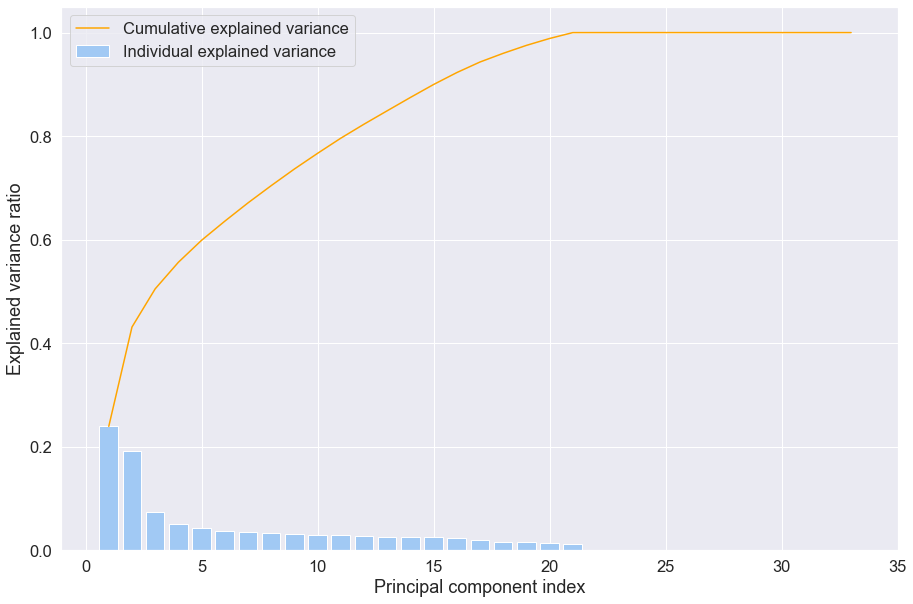

In [226]:
exp_var_pca = pca_transform.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(1,len(exp_var_pca)+1), exp_var_pca, align='center', label='Individual explained variance')
plt.plot(range(1,len(cum_sum_eigenvalues)+1), cum_sum_eigenvalues, label='Cumulative explained variance', color='orange')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend()
plt.savefig("PCA_index.pdf")

In [228]:
cum_sum_eigenvalues[11]   # 12th > 80

0.8230166881747389

In [229]:
pca = pca[:, :11]
pca.shape

(7021, 11)

## Clusterization after dimension reduction

### Metoda Silhouette


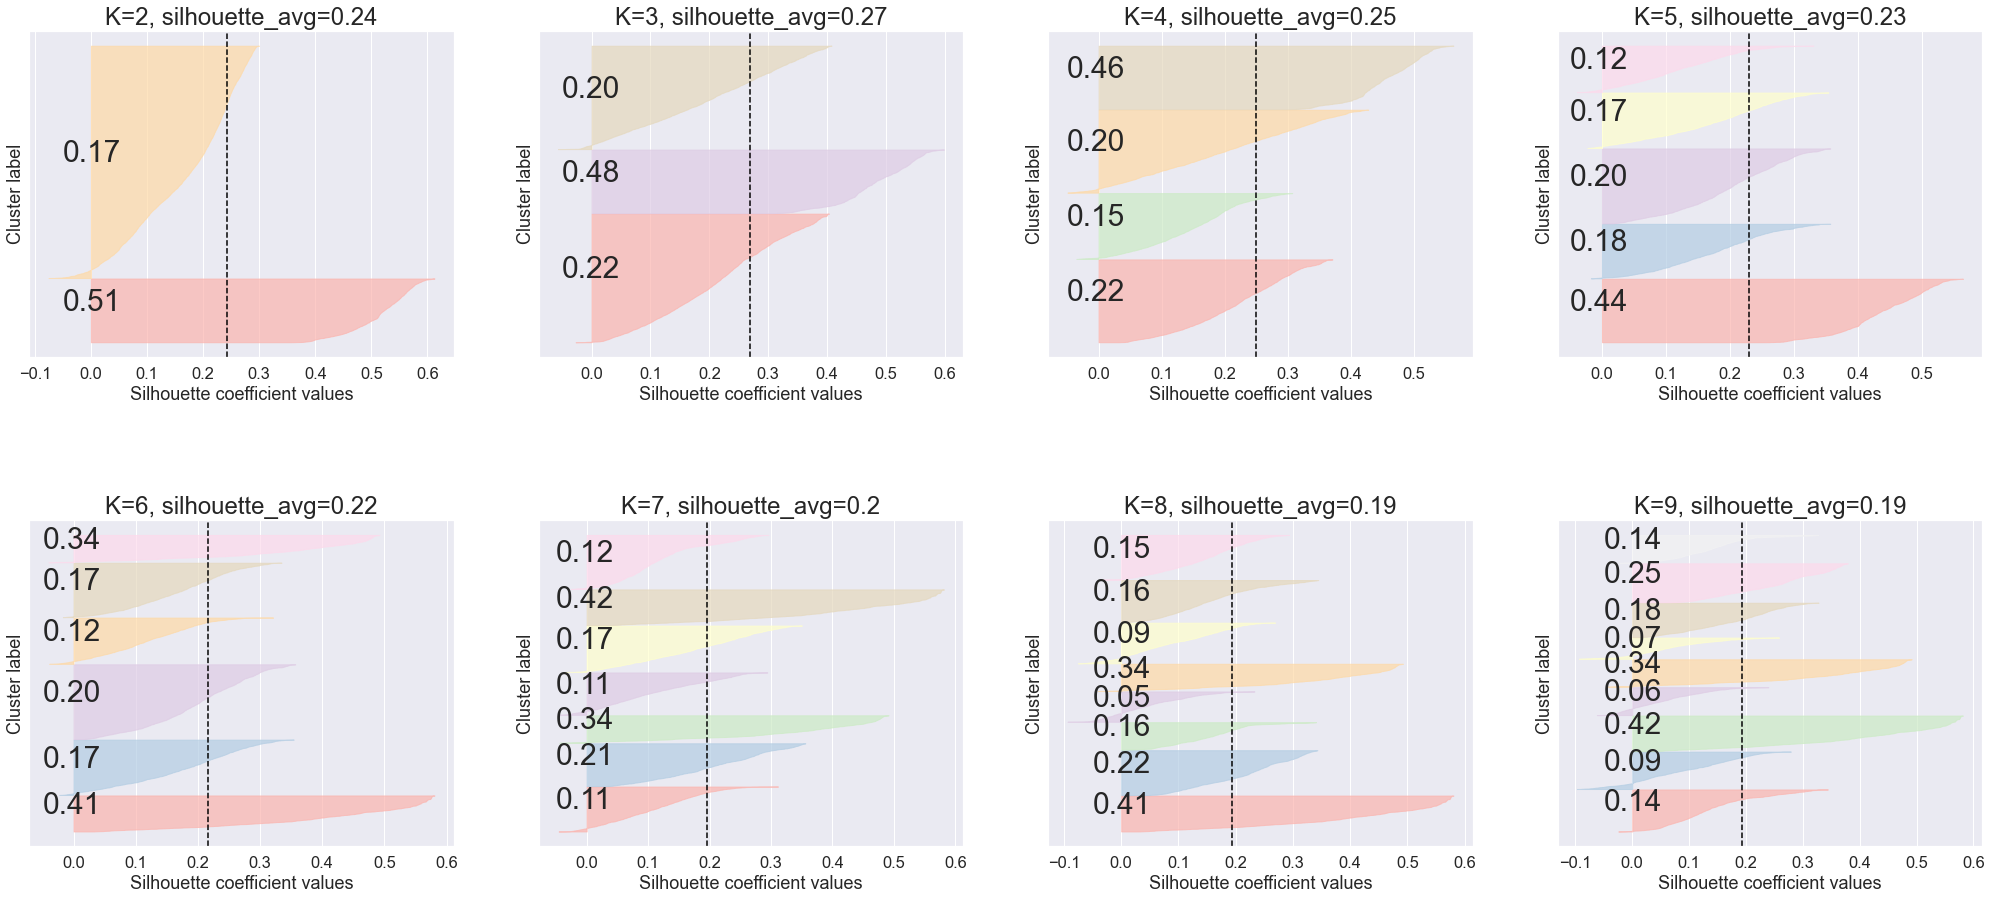

In [232]:
def optimise_k_means_silhouette_score(data, max_k):
    means = []
    silhouette = []

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        means.append(k)
        silhouette.append(silhouette_score(data, kmeans.labels_))

    plt.plot(means, silhouette, "o-", color="black")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Average Silhouette Score")
    plt.grid(True)
    plt.savefig("images_clustering/silhouette_scorePCA.pdf")
    plt.show()
    
k_values = range(2, 10)
pastel_cmap = plt.get_cmap("Pastel1")
fig, axs = plt.subplots(2, 4, figsize=(35, 15))
fig.subplots_adjust(hspace=0.5)
axs = axs.flatten()
table = []
for idx, k in enumerate(k_values):
    plt.sca(axs[idx])
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(pca)
    silhouette_avg = silhouette_score(pca, cluster_labels)
    sample_silhouette_values = silhouette_samples(pca, cluster_labels)
    y_lower = 10
    table.append(silhouette_avg)

    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = pastel_cmap(float(i) / k)
        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        plt.text(
            -0.05,
            y_lower + 0.5 * size_cluster_i,
            f"{ith_cluster_silhouette_values.mean():.2f}",
        )  # Write silhouette coefficient value
        y_lower = y_upper + 10
    plt.title(f"K={k}, silhouette_avg={np.round(silhouette_avg, 2)}", fontsize=24)
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")
    plt.axvline(x=silhouette_avg, color="black", linestyle="--")
    plt.yticks([])
    plt.savefig("images_clustering/silhouette_scoresPCA.pdf")
    


In [231]:
pd.DataFrame(table, index=k_values, columns=["Silhouette Score"])

Silhouette Score
2          0.243068
3          0.269017
4          0.249427
5          0.229730
6          0.216190
7          0.195494
8          0.193153
9          0.192254

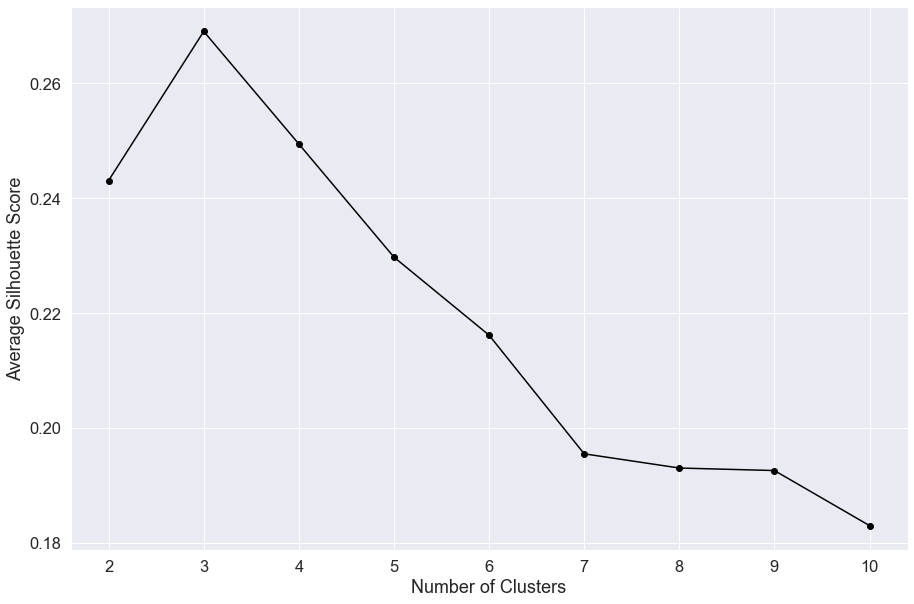

In [233]:
optimise_k_means_silhouette_score(pca, 10)

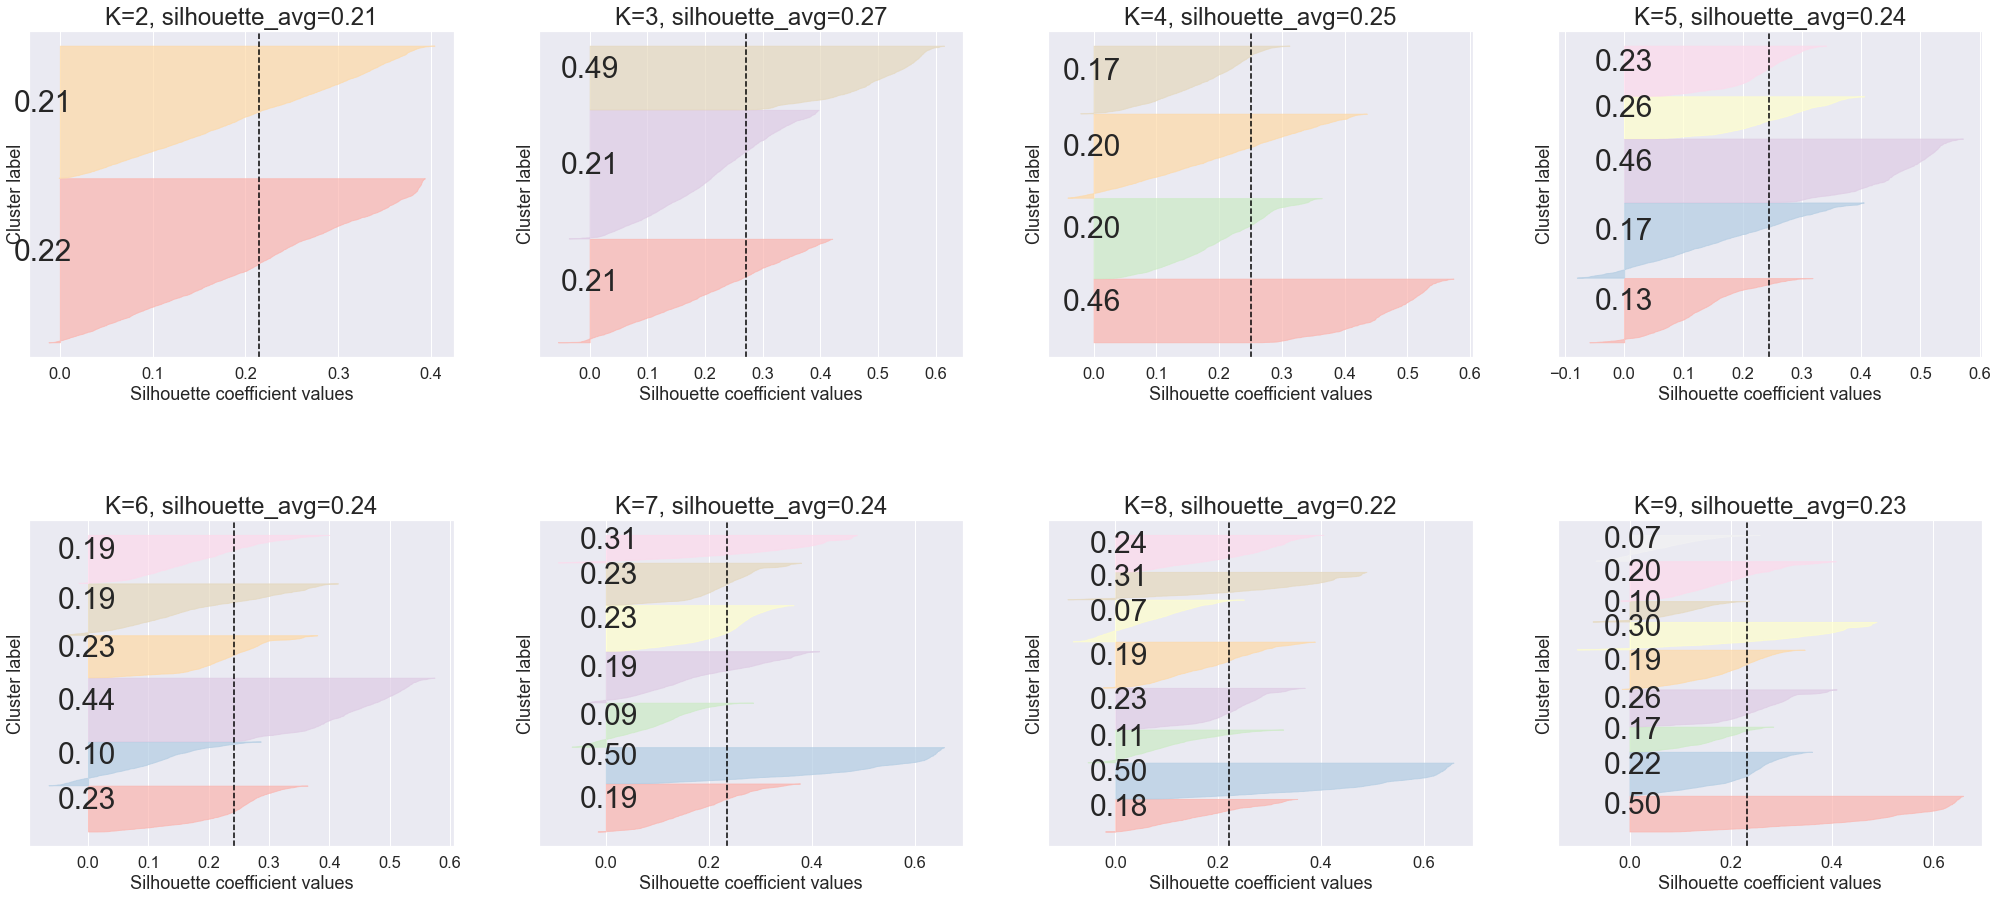

In [95]:
def optimise_k_means_silhouette_score(data, max_k):
    means = []
    silhouette = []

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        means.append(k)
        silhouette.append(silhouette_score(data, kmeans.labels_))

    plt.plot(means, silhouette, "o-", color="black")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Average Silhouette Score")
    plt.grid(True)
    plt.savefig("images_clustering/silhouette_scoreMDS.pdf")
    plt.show()
    
k_values = range(2, 10)
pastel_cmap = plt.get_cmap("Pastel1")
fig, axs = plt.subplots(2, 4, figsize=(35, 15))
fig.subplots_adjust(hspace=0.5)
axs = axs.flatten()
table = []
for idx, k in enumerate(k_values):
    plt.sca(axs[idx])
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(pca)
    silhouette_avg = silhouette_score(pca, cluster_labels)
    sample_silhouette_values = silhouette_samples(pca, cluster_labels)
    y_lower = 10
    table.append(silhouette_avg)

    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = pastel_cmap(float(i) / k)
        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        plt.text(
            -0.05,
            y_lower + 0.5 * size_cluster_i,
            f"{ith_cluster_silhouette_values.mean():.2f}",
        )  # Write silhouette coefficient value
        y_lower = y_upper + 10
    plt.title(f"K={k}, silhouette_avg={np.round(silhouette_avg, 2)}", fontsize=24)
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")
    plt.axvline(x=silhouette_avg, color="black", linestyle="--")
    plt.yticks([])
    plt.savefig("images_clustering/silhouette_scoresMDS.pdf")
    


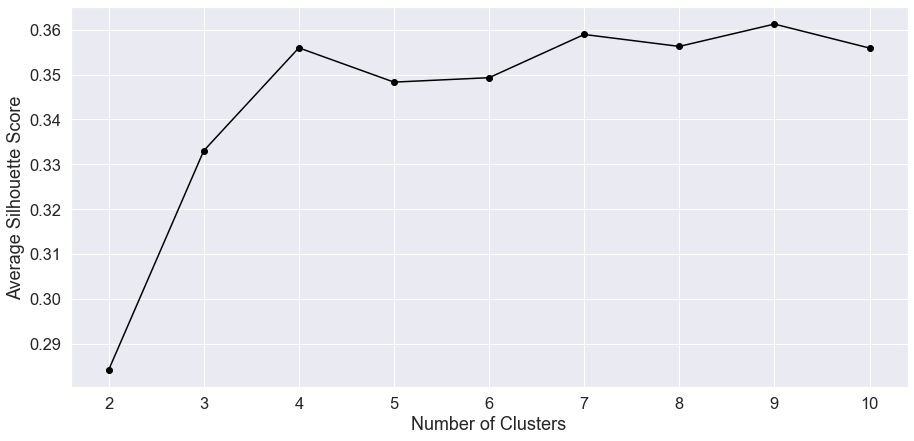

In [96]:
optimise_k_means_silhouette_score(mds, 10)

### Metoda Daviesa-Bouldina

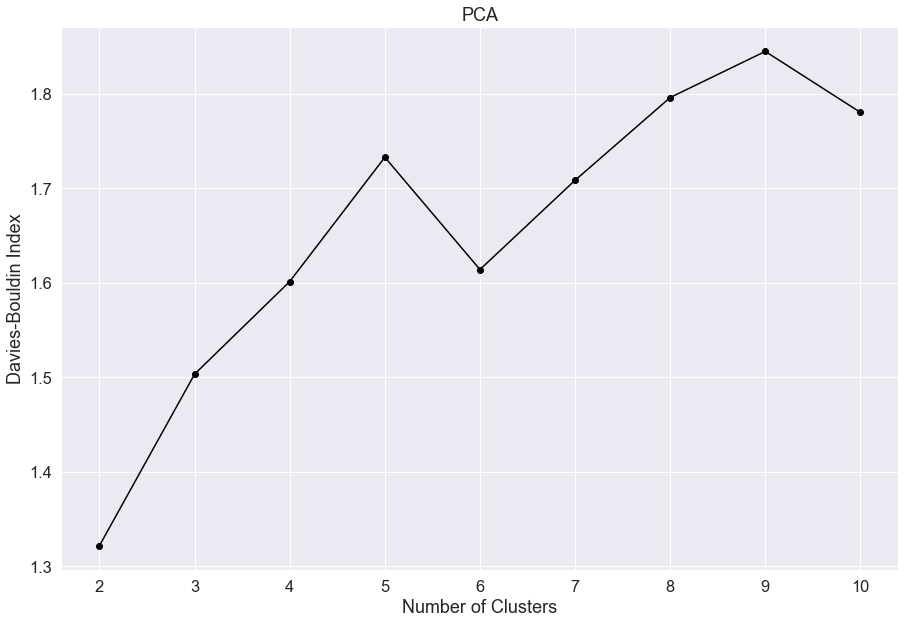

In [234]:
def optimise_k_means_davies_bouldin(data, max_k):
    davies_bouldin_scores = []

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        db_index = davies_bouldin_score(data, kmeans.labels_)
        davies_bouldin_scores.append(db_index)

    plt.plot(range(2, max_k + 1), davies_bouldin_scores, "o-", color="black")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Davies-Bouldin Index")
    plt.title('PCA')
    plt.grid(True)
    plt.savefig("images_clustering/davies_bouldinPCA.pdf")
    plt.show()
optimise_k_means_davies_bouldin(pca, 10)

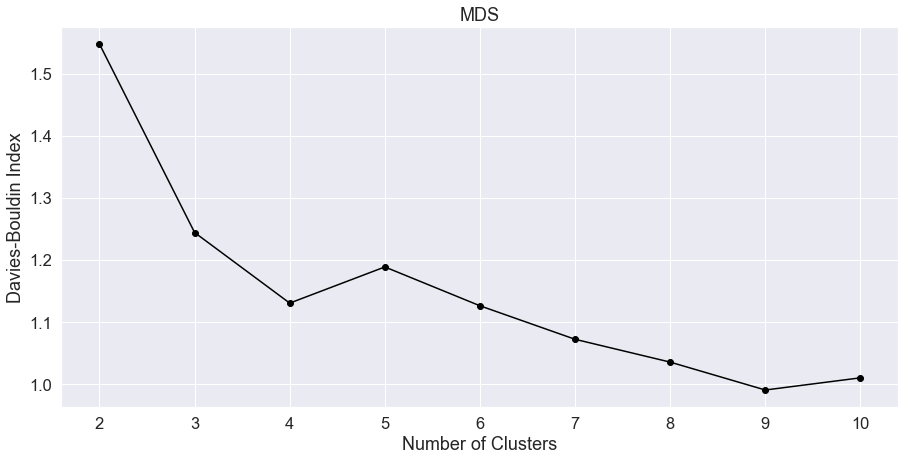

In [94]:
def optimise_k_means_davies_bouldin(data, max_k):
    davies_bouldin_scores = []

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        db_index = davies_bouldin_score(data, kmeans.labels_)
        davies_bouldin_scores.append(db_index)

    plt.plot(range(2, max_k + 1), davies_bouldin_scores, "o-", color="black")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Davies-Bouldin Index")
    plt.title('MDS')
    plt.grid(True)
    plt.savefig("images_clustering/davies_bouldinMDS.pdf")
    plt.show()
optimise_k_means_davies_bouldin(mds, 10)

### calinski Harabasz

For n_clusters = 2, Calinski-Harabasz Index is 1964.315642611755
For n_clusters = 3, Calinski-Harabasz Index is 2336.0117891307
For n_clusters = 4, Calinski-Harabasz Index is 2085.2388101087186
For n_clusters = 5, Calinski-Harabasz Index is 1847.7503678919365
For n_clusters = 6, Calinski-Harabasz Index is 1686.1746320663522
For n_clusters = 7, Calinski-Harabasz Index is 1552.6680890563814
For n_clusters = 8, Calinski-Harabasz Index is 1425.322579241222
For n_clusters = 9, Calinski-Harabasz Index is 1321.5959867693741
For n_clusters = 10, Calinski-Harabasz Index is 1235.7449879264548
The best number of clusters is 3 based on Calinski-Harabasz Index.


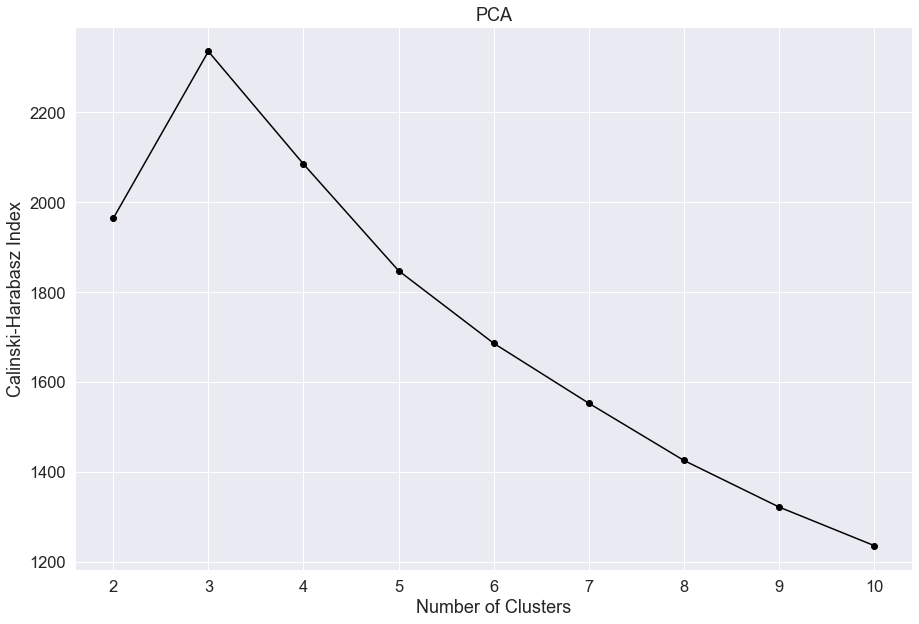

3

In [235]:
def optimise_k_means_calinski_harabasz(data):
    ch_index_values = []
    k_values = range(2, 11)

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        ch_index = calinski_harabasz_score(data, cluster_labels)
        ch_index_values.append(ch_index)
        print(f"For n_clusters = {k}, Calinski-Harabasz Index is {ch_index}")

    best_k = k_values[np.argmax(ch_index_values)]
    print(f"The best number of clusters is {best_k} based on Calinski-Harabasz Index.")

    plt.plot(k_values, ch_index_values, "o-", color="black")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Calinski-Harabasz Index")
    plt.grid(True)
    plt.title('PCA')
    plt.savefig("images_clustering/calinski_harabaszPCA.pdf")
    
    plt.show()

    return best_k

optimise_k_means_calinski_harabasz(pca)

For n_clusters = 2, Calinski-Harabasz Index is 2764.177888434819
For n_clusters = 3, Calinski-Harabasz Index is 2981.231808450255
For n_clusters = 4, Calinski-Harabasz Index is 3180.74209130675
For n_clusters = 5, Calinski-Harabasz Index is 3104.8690024446396
For n_clusters = 6, Calinski-Harabasz Index is 3077.7475860829927
For n_clusters = 7, Calinski-Harabasz Index is 3087.8675948341775
For n_clusters = 8, Calinski-Harabasz Index is 3009.771488561776
For n_clusters = 9, Calinski-Harabasz Index is 2999.6748632455915
For n_clusters = 10, Calinski-Harabasz Index is 2879.322063321195
The best number of clusters is 4 based on Calinski-Harabasz Index.


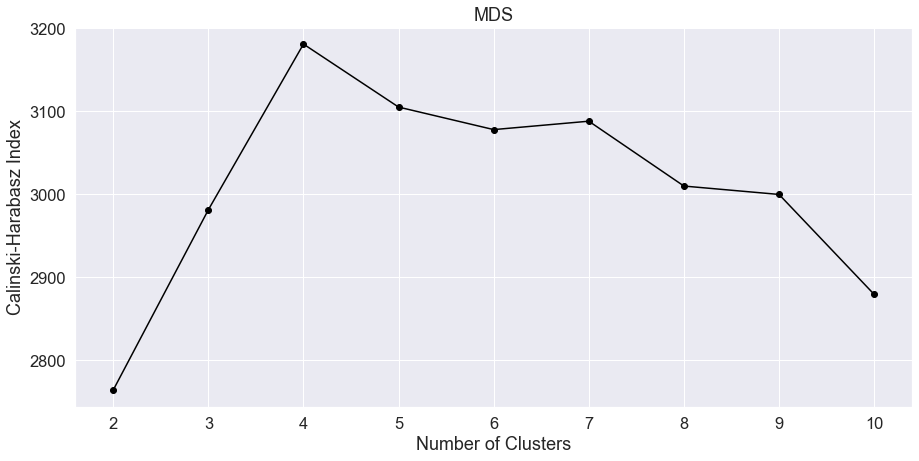

4

In [99]:
def optimise_k_means_calinski_harabasz(data):
    ch_index_values = []
    k_values = range(2, 11)

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        ch_index = calinski_harabasz_score(data, cluster_labels)
        ch_index_values.append(ch_index)
        print(f"For n_clusters = {k}, Calinski-Harabasz Index is {ch_index}")

    best_k = k_values[np.argmax(ch_index_values)]
    print(f"The best number of clusters is {best_k} based on Calinski-Harabasz Index.")

    plt.plot(k_values, ch_index_values, "o-", color="black")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Calinski-Harabasz Index")
    plt.grid(True)
    plt.title('MDS')
    plt.savefig("images_clustering/calinski_harabaszMDS.pdf")
    
    plt.show()

    return best_k

optimise_k_means_calinski_harabasz(mds)

### Analiza Hierarchiczna:


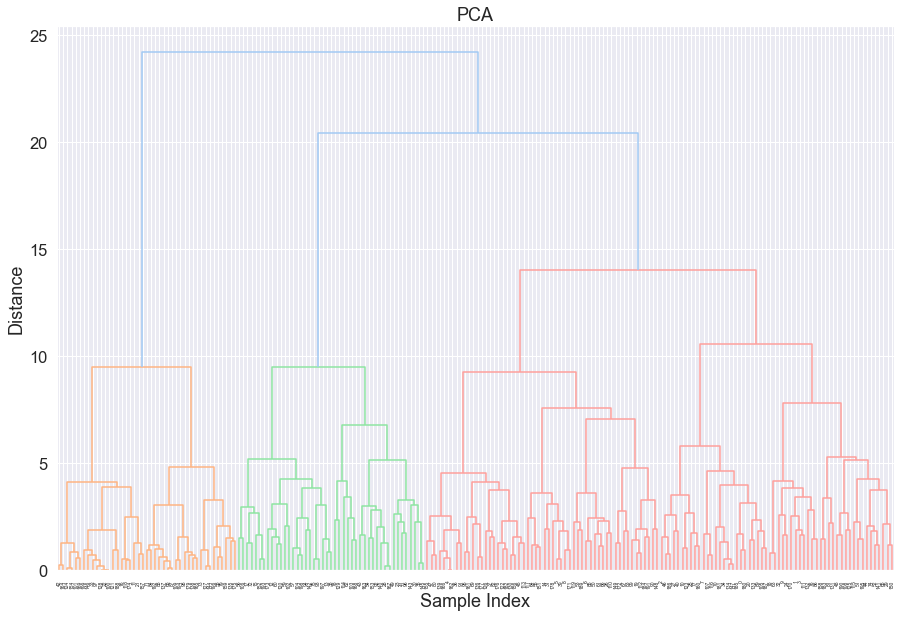

In [236]:
linkage_matrix = linkage(
    pca[:200], method="ward"
)  # dałam okrojony zbiór, bo inaczej za długo liczyło
dendrogram(linkage_matrix)
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.title('PCA')
plt.savefig("images_clustering/dendrogramPCA.pdf")
plt.show()

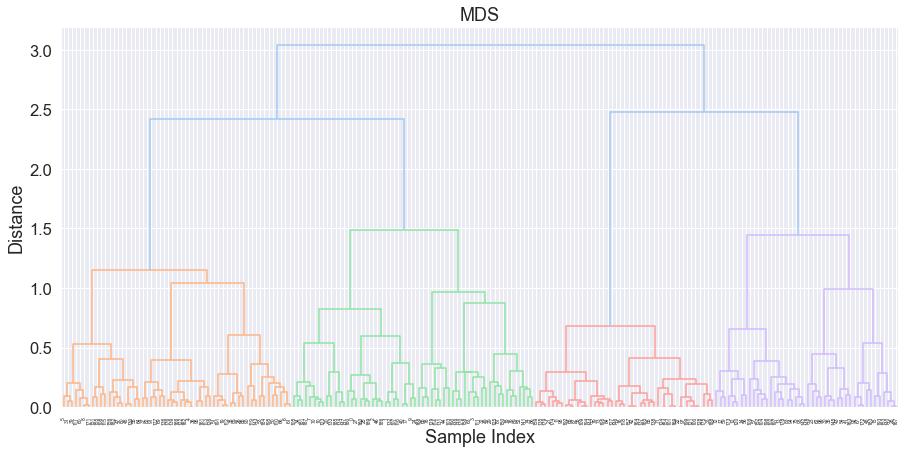

In [102]:
linkage_matrix = linkage(
    mds[:200], method="ward"
)  # dałam okrojony zbiór, bo inaczej za długo liczyło
dendrogram(linkage_matrix)
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.title('MDS')
plt.savefig("images_clustering/dendrogramMDS.pdf")
plt.show()

### Wizualizacja

In [67]:
pca.shape

(7021, 10)

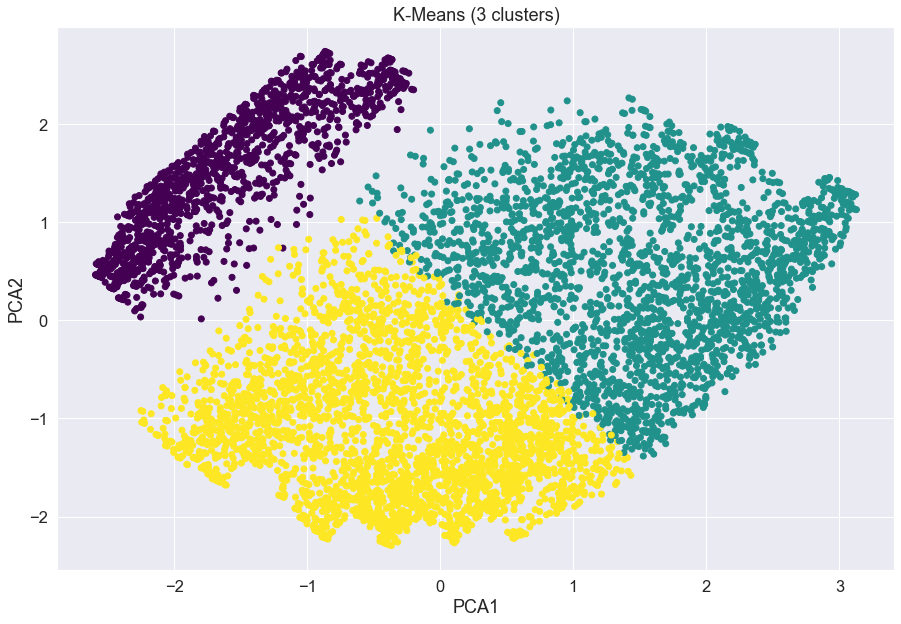

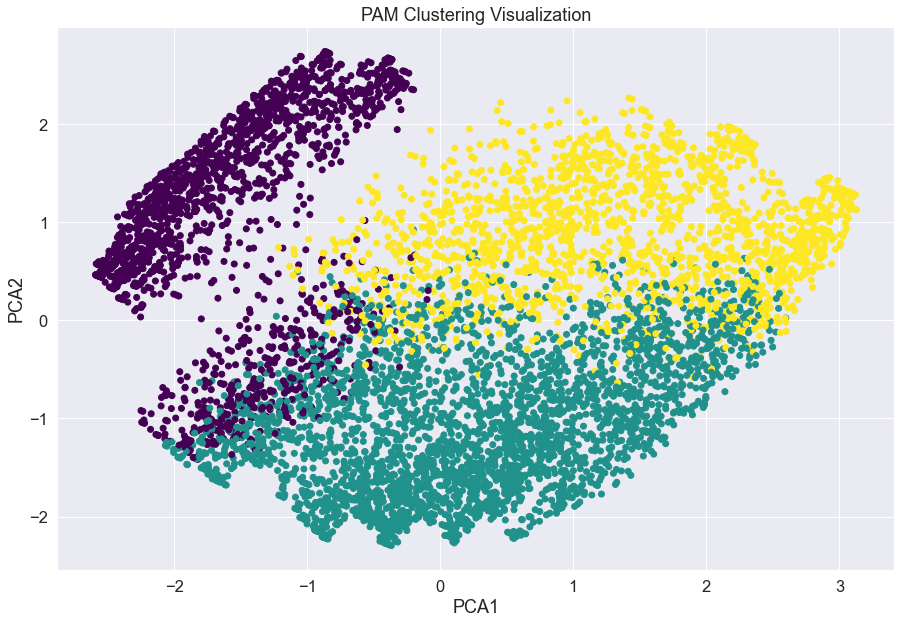

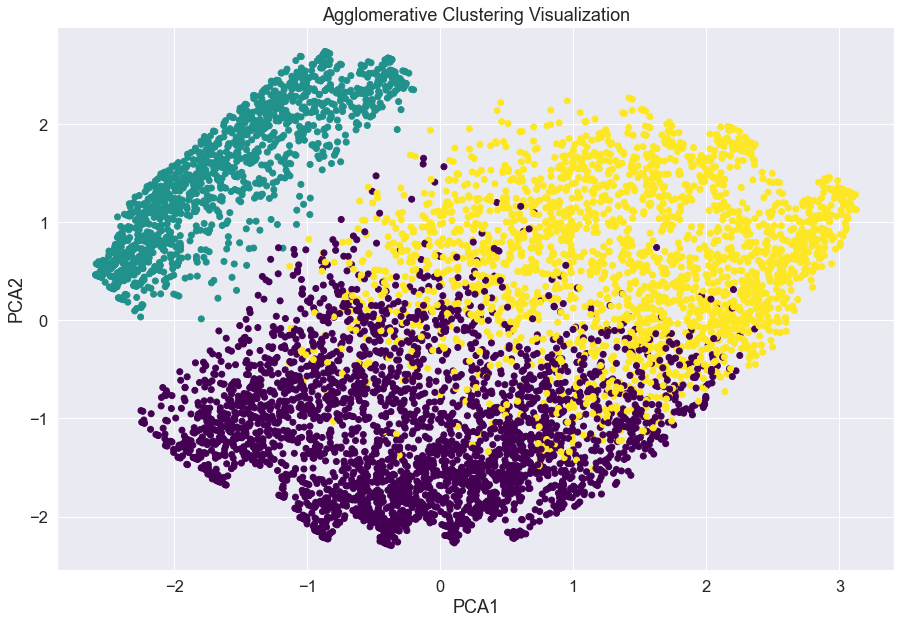

In [238]:
# fig, axs = plt.subplots(1, 3, figsize=(25, 25))
# change fontsize for titles
# plt.rcParams.update({"font.size": 30})


kmeans = KMeans(n_clusters=3)

kmeans.fit(pca)
plt.scatter(
    pca[:, 0], pca[:, 1], c=kmeans.labels_, cmap="viridis"
)
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("K-Means (3 clusters)")
plt.savefig("images_clustering/KmeansPCA.pdf")
plt.show()

# # PAM with 3 clusters
PAM = KMedoids(n_clusters=3)
PAM.fit(pca)
plt.scatter(
    pca[:, 0], pca[:, 1], c=PAM.labels_, cmap="viridis"
)

plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("PAM Clustering Visualization")
plt.savefig("images_clustering/PamPCA.pdf")
plt.show()

# # Agglomerative with 3 clusters
agg = AgglomerativeClustering(n_clusters=3)
agg.fit(pca)
plt.scatter(
    pca[:, 0], pca[:, 1], c=agg.labels_, cmap="viridis"
)

plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("Agglomerative Clustering Visualization")
plt.savefig("images_clustering/AggPCA.pdf")

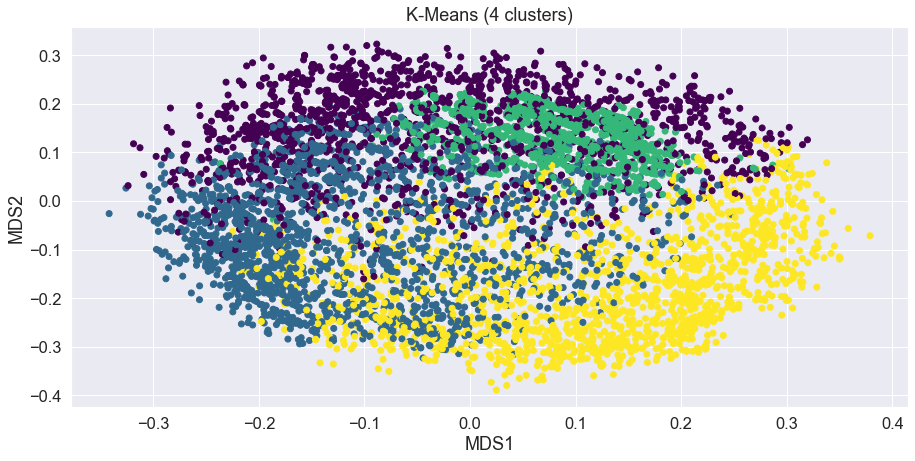

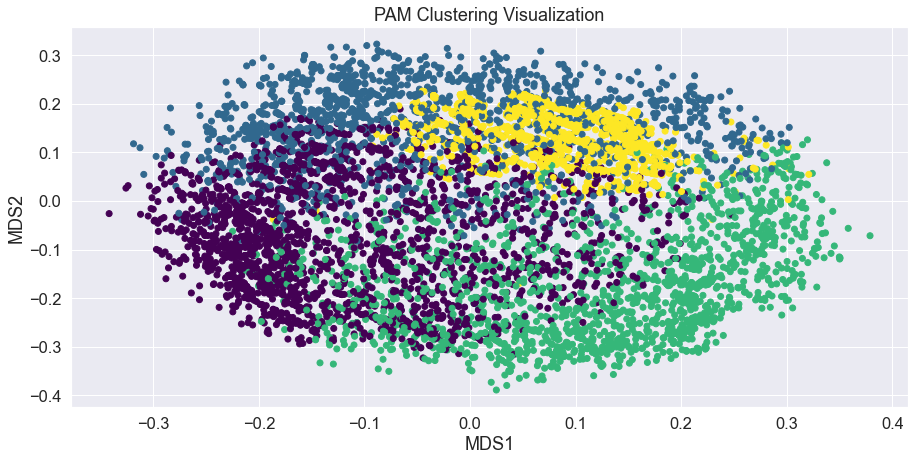

Text(0.5, 1.0, 'Agglomerative Clustering Visualization')

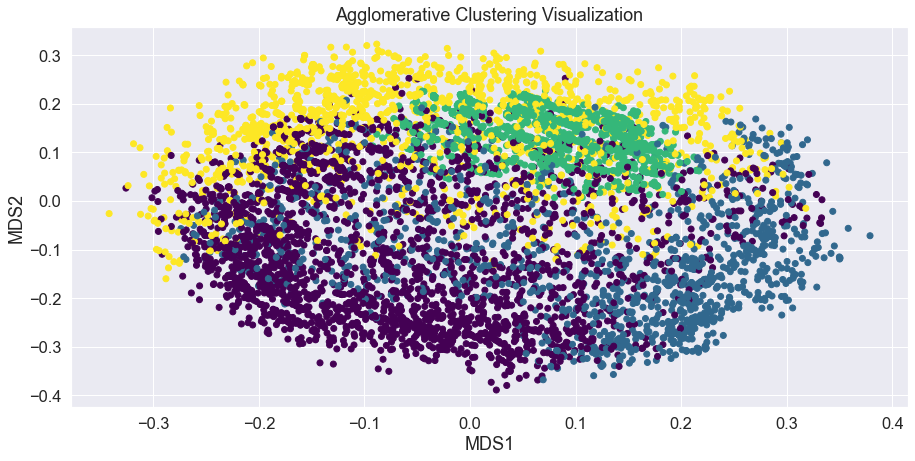

In [104]:

kmeans = KMeans(n_clusters=4)

kmeans.fit(mds)
plt.scatter(
    mds[:, 0], mds[:, 1], c=kmeans.labels_, cmap="viridis"
)
plt.xlabel("MDS1")
plt.ylabel("MDS2")
plt.title("K-Means (4 clusters)")
plt.show()

# # PAM with 4 clusters
PAM = KMedoids(n_clusters=4)
PAM.fit(mds)
plt.scatter(
    mds[:, 0], mds[:, 1], c=PAM.labels_, cmap="viridis"
)

plt.xlabel("MDS1")
plt.ylabel("MDS2")
plt.title("PAM Clustering Visualization")
plt.show()

# # Agglomerative with 4 clusters
agg = AgglomerativeClustering(n_clusters=4)
agg.fit(mds)
plt.scatter(
    mds[:, 0], mds[:, 1], c=agg.labels_, cmap="viridis"
)

plt.xlabel("MDS1")
plt.ylabel("MDS2")
plt.title("Agglomerative Clustering Visualization")

# Classification


In [138]:
from imblearn import over_sampling, under_sampling #RandomOverSampler, RandomUnderSampler
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [239]:
X_train_pca, X_test_pca, y_train, y_test = train_test_split(pca, y, test_size=0.2, random_state=31)
X_train_mds, X_test_mds, y_train, y_test = train_test_split(mds, y, test_size=0.2, random_state=31)

In [240]:
X_pca_over, y_pca_over = over_sampling.RandomOverSampler(random_state=32).fit_resample(X_train_pca, y_train)
X_pca_under, y_pca_under = under_sampling.RandomUnderSampler(random_state=33).fit_resample(X_train_pca, y_train)

X_mds_over, y_over = over_sampling.RandomOverSampler(random_state=32).fit_resample(X_train_mds, y_train)
X_mds_under, y_under = under_sampling.RandomUnderSampler(random_state=33).fit_resample(X_train_mds, y_train)


In [241]:
# The same values in both groups
np.sum((y_over == y_pca_over)) == y_over.shape[0]

# So we will use only y_over and y_under - because for PCA it is exactly the same

True

## 1. KNN

In [136]:
n_values = range(1, 100)

### 1.1 PCA


n: 22 Acc: 0.801423487544484


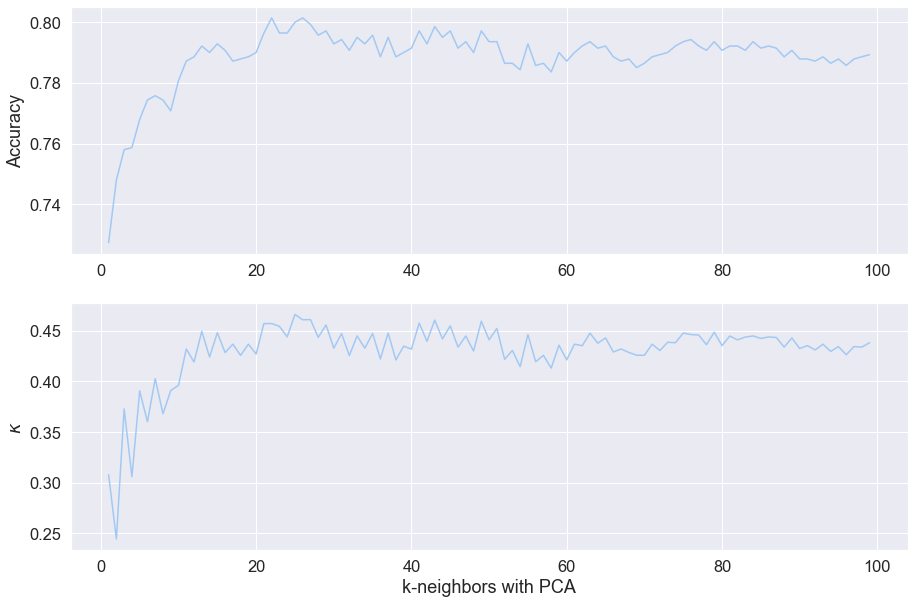

In [242]:
best_n = None
best_accuracy = 0
accuracy_values = []
kappa = []

for n in n_values:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train_pca, y_train)
    y_pred = knn.predict(X_test_pca)
    
    accuracy = knn.score(X_test_pca, y_test)
    accuracy_values.append(accuracy)
    kappa.append(cohen_kappa_score(y_pred, y_test))
    if accuracy > best_accuracy:
        best_n = n
        best_accuracy = accuracy
        

print('n:', best_n, 'Acc:', accuracy_values[best_n-1])
plt.subplot(211)
plt.plot(n_values, accuracy_values)
plt.ylabel("Accuracy")
plt.subplot(212)
plt.plot(n_values, kappa)

plt.xlabel("k-neighbors with PCA")
plt.ylabel(r"$\kappa$")
plt.savefig('knn_n_PCA.pdf')

In [244]:
kappa[best_n-1]

0.45731492056899603

Acc = 0.801423487544484
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1015
           1       0.70      0.50      0.58       390

    accuracy                           0.80      1405
   macro avg       0.76      0.71      0.73      1405
weighted avg       0.79      0.80      0.79      1405

0.45731492056899603


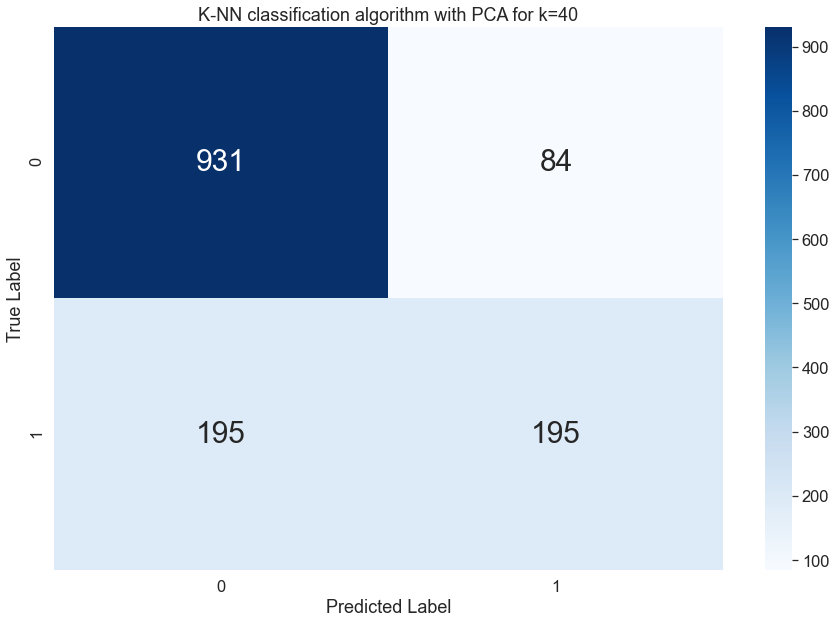

In [246]:
knn = KNeighborsClassifier(n_neighbors=22)
knn.fit(X_train_pca, y_train)
y_pred = knn.predict(X_test_pca)
print(f'Acc = {knn.score(X_test_pca, y_test)}')
print(classification_report(y_test, y_pred))

print(cohen_kappa_score(y_test, y_pred))

#generating confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g')
plt.title(fr'K-NN classification algorithm with PCA for k={40}')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

#### Over-Under Sampling

0.801423487544484
0.7352313167259786
0.7217081850533807
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1015
           1       0.70      0.50      0.58       390

    accuracy                           0.80      1405
   macro avg       0.76      0.71      0.73      1405
weighted avg       0.79      0.80      0.79      1405

              precision    recall  f1-score   support

           0       0.89      0.72      0.80      1015
           1       0.52      0.77      0.62       390

    accuracy                           0.74      1405
   macro avg       0.70      0.75      0.71      1405
weighted avg       0.79      0.74      0.75      1405

              precision    recall  f1-score   support

           0       0.89      0.70      0.78      1015
           1       0.50      0.78      0.61       390

    accuracy                           0.72      1405
   macro avg       0.70      0.74      0.70      1405
weighted avg      

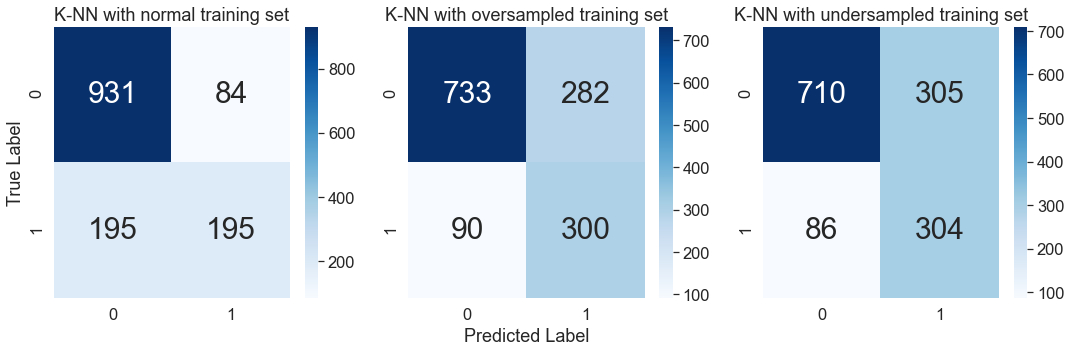

In [247]:
knn = KNeighborsClassifier(n_neighbors=22)

knn_model = KNeighborsClassifier(n_neighbors=22).fit(X_train_pca, y_train)
knn_over = KNeighborsClassifier(n_neighbors=22).fit(X_pca_over, y_over)
knn_under = KNeighborsClassifier(n_neighbors=22).fit(X_pca_under, y_under)
print(knn_model.score(X_test_pca, y_test))
print(knn_over.score(X_test_pca, y_test))
print(knn_under.score(X_test_pca, y_test))

knn_pred =knn_model.predict(X_test_pca)
print(classification_report(y_test, knn_pred))
knn_over_pred = knn_over.predict(X_test_pca)
print(classification_report(y_test, knn_over_pred))
knn_under_pred =knn_under.predict(X_test_pca)
print(classification_report(y_test, knn_under_pred))

print(cohen_kappa_score(y_test, knn_pred))
print(cohen_kappa_score(y_test, knn_over_pred))
print(cohen_kappa_score(y_test, knn_under_pred))



#generating confusion matrix
plt.rcParams["figure.figsize"] = (18, 5)
plt.subplot(131)
sns.heatmap(confusion_matrix(y_test, knn_pred), annot=True, cmap='Blues', fmt='g')
plt.ylabel("True Label")
plt.title('K-NN with normal training set')
plt.subplot(132)
sns.heatmap(confusion_matrix(y_test, knn_over_pred), annot=True, cmap='Blues', fmt='g')

plt.xlabel("Predicted Label")
plt.title('K-NN with oversampled training set')
plt.subplot(133)
sns.heatmap(confusion_matrix(y_test, knn_under_pred), annot=True, cmap='Blues', fmt='g')
plt.title('K-NN with undersampled training set')


plt.savefig('knn_conf_matixPCA.pdf')
plt.show()
plt.rcParams["figure.figsize"] = (15, 10)

### 1.1 MDS


n: 1 Acc: 0.900355871886121


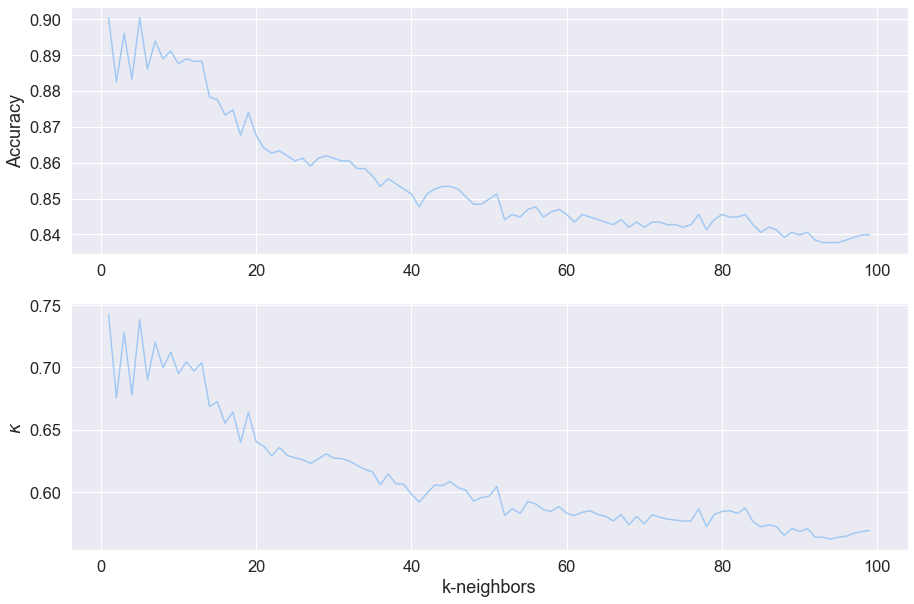

In [148]:
best_n = None
best_accuracy = 0
accuracy_values = []
kappa = []

for n in n_values:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train_mds, y_train)
    y_pred = knn.predict(X_test_mds)
    
    accuracy = knn.score(X_test_mds, y_test)
    accuracy_values.append(accuracy)
    kappa.append(cohen_kappa_score(y_pred, y_test))
    if accuracy > best_accuracy:
        best_n = n
        best_accuracy = accuracy
        

print('n:', best_n, 'Acc:', accuracy_values[best_n-1])
plt.subplot(211)
plt.plot(n_values, accuracy_values)
plt.ylabel("Accuracy")
plt.subplot(212)
plt.plot(n_values, kappa)

plt.xlabel("k-neighbors")
plt.ylabel(r"$\kappa$")
plt.savefig('knn_n_MDS.pdf')

0.900355871886121
0.900355871886121
0.8761565836298932
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1015
           1       0.86      0.76      0.81       390

    accuracy                           0.90      1405
   macro avg       0.89      0.86      0.87      1405
weighted avg       0.90      0.90      0.90      1405

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1015
           1       0.86      0.76      0.81       390

    accuracy                           0.90      1405
   macro avg       0.89      0.86      0.87      1405
weighted avg       0.90      0.90      0.90      1405

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1015
           1       0.75      0.84      0.79       390

    accuracy                           0.88      1405
   macro avg       0.84      0.86      0.85      1405
weighted avg       

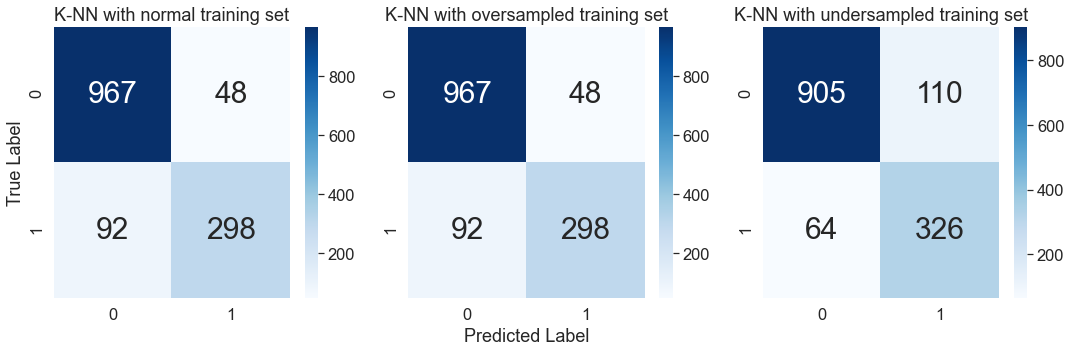

In [153]:
knn = KNeighborsClassifier(n_neighbors=1)

knn_model = KNeighborsClassifier(n_neighbors=1).fit(X_train_mds, y_train)
knn_over = KNeighborsClassifier(n_neighbors=1).fit(X_mds_over, y_over)
knn_under = KNeighborsClassifier(n_neighbors=1).fit(X_mds_under, y_under)
print(knn_model.score(X_test_mds, y_test))
print(knn_over.score(X_test_mds, y_test))
print(knn_under.score(X_test_mds, y_test))

knn_pred =knn_model.predict(X_test_mds)
print(classification_report(y_test, knn_pred))
knn_over_pred = knn_over.predict(X_test_mds)
print(classification_report(y_test, knn_over_pred))
knn_under_pred =knn_under.predict(X_test_mds)
print(classification_report(y_test, knn_under_pred))

print(cohen_kappa_score(y_test, knn_pred))
print(cohen_kappa_score(y_test, knn_over_pred))
print(cohen_kappa_score(y_test, knn_under_pred))



#generating confusion matrix
plt.rcParams["figure.figsize"] = (18, 5)
plt.subplot(131)
sns.heatmap(confusion_matrix(y_test, knn_pred), annot=True, cmap='Blues', fmt='g')
plt.ylabel("True Label")
plt.title('K-NN with normal training set')
plt.subplot(132)
sns.heatmap(confusion_matrix(y_test, knn_over_pred), annot=True, cmap='Blues', fmt='g')

plt.xlabel("Predicted Label")
plt.title('K-NN with oversampled training set')
plt.subplot(133)
sns.heatmap(confusion_matrix(y_test, knn_under_pred), annot=True, cmap='Blues', fmt='g')
plt.title('K-NN with undersampled training set')


plt.savefig('knn_conf_matixMDS.pdf')
plt.show()
plt.rcParams["figure.figsize"] = (15, 10)

## 2. LDA & QDA

In [150]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

### 2.1 PCA


0.797864768683274
0.46651514138645633
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1015
           1       0.67      0.55      0.60       390

    accuracy                           0.80      1405
   macro avg       0.75      0.72      0.73      1405
weighted avg       0.79      0.80      0.79      1405

0.7459074733096085
0.7437722419928826
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1015
           1       0.53      0.81      0.64       390

    accuracy                           0.75      1405
   macro avg       0.72      0.76      0.72      1405
weighted avg       0.80      0.75      0.76      1405

              precision    recall  f1-score   support

           0       0.89      0.70      0.78      1015
           1       0.50      0.78      0.61       390

    accuracy                           0.72      1405
   macro avg       0.70      0.74      0.70      140

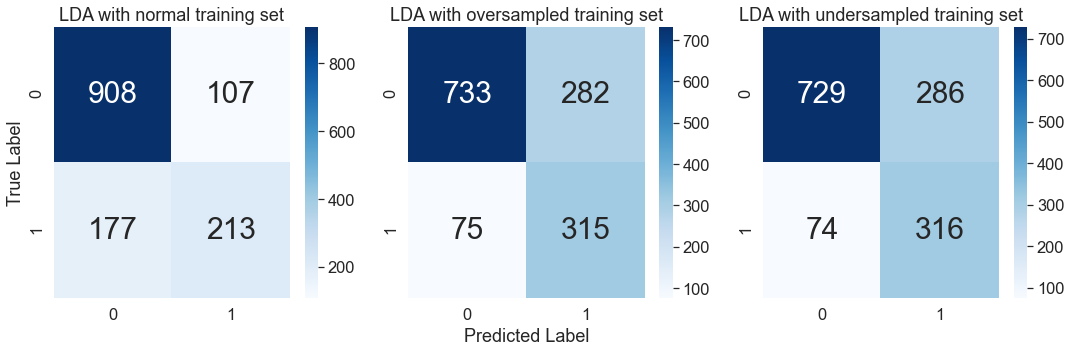

In [248]:
# Normal
lda = LinearDiscriminantAnalysis().fit(X_train_pca, y_train)
print(lda.score(X_test_pca, y_test))

lda_pred = lda.predict(X_test_pca)
#print(classification_report(y_test, lda_pred))
print(cohen_kappa_score(y_test, lda_pred))
print(classification_report(y_test, lda_pred))

# Over-under sampling
lda_over = LinearDiscriminantAnalysis().fit(X_pca_over, y_over)
lda_under = LinearDiscriminantAnalysis().fit(X_pca_under, y_under)

print(lda_over.score(X_test_pca, y_test))
print(lda_under.score(X_test_pca, y_test))

lda_over_pred = lda_over.predict(X_test_pca)
print(classification_report(y_test, lda_over_pred))

lda_under_pred = lda_under.predict(X_test_pca)
print(classification_report(y_test, knn_under_pred))

print(cohen_kappa_score(y_test, lda_over_pred))
print(cohen_kappa_score(y_test, lda_under_pred))

#generating confusion matrix
plt.rcParams["figure.figsize"] = (18, 5)
plt.subplot(131)
sns.heatmap(confusion_matrix(y_test, lda_pred), annot=True, cmap='Blues', fmt='g')
plt.ylabel("True Label")
plt.title('LDA with normal training set')
plt.subplot(132)
sns.heatmap(confusion_matrix(y_test, lda_over_pred), annot=True, cmap='Blues', fmt='g')

plt.xlabel("Predicted Label")
plt.title('LDA with oversampled training set')
plt.subplot(133)
sns.heatmap(confusion_matrix(y_test, lda_under_pred), annot=True, cmap='Blues', fmt='g')
plt.title('LDA with undersampled training set')


plt.savefig('lda_conf_matixPCA.pdf')
plt.show()
plt.rcParams["figure.figsize"] = (15, 10)


0.7736654804270463
0.4691814185576809
              precision    recall  f1-score   support

           0       0.87      0.80      0.84      1015
           1       0.58      0.69      0.63       390

    accuracy                           0.77      1405
   macro avg       0.72      0.75      0.73      1405
weighted avg       0.79      0.77      0.78      1405

0.7266903914590748
0.7288256227758008
              precision    recall  f1-score   support

           0       0.91      0.69      0.78      1015
           1       0.50      0.82      0.62       390

    accuracy                           0.73      1405
   macro avg       0.71      0.76      0.70      1405
weighted avg       0.80      0.73      0.74      1405

              precision    recall  f1-score   support

           0       0.91      0.69      0.79      1015
           1       0.51      0.82      0.63       390

    accuracy                           0.73      1405
   macro avg       0.71      0.76      0.71      140

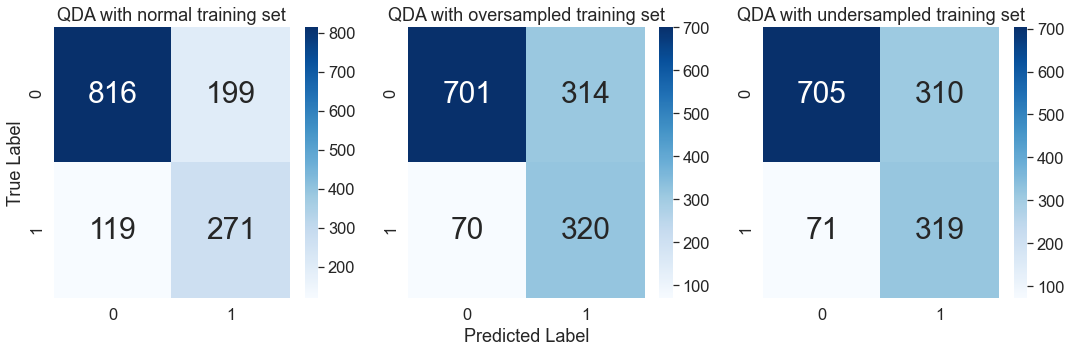

In [249]:
# Normal
qda = QuadraticDiscriminantAnalysis().fit(X_train_pca, y_train)
print(qda.score(X_test_pca, y_test))

qda_pred = qda.predict(X_test_pca)
#print(classification_report(y_test, lda_pred))
print(cohen_kappa_score(y_test, qda_pred))
print(classification_report(y_test, qda_pred))

# Over-under sampling
qda_over = QuadraticDiscriminantAnalysis().fit(X_pca_over, y_over)
qda_under = QuadraticDiscriminantAnalysis().fit(X_pca_under, y_under)

print(qda_over.score(X_test_pca, y_test))

print(qda_under.score(X_test_pca, y_test))


qda_over_pred = qda_over.predict(X_test_pca)
print(classification_report(y_test, qda_over_pred))
qda_under_pred = qda_under.predict(X_test_pca)
print(classification_report(y_test, qda_under_pred))
print(cohen_kappa_score(y_test, qda_over_pred))
print(cohen_kappa_score(y_test, qda_under_pred))

#generating confusion matrix
plt.rcParams["figure.figsize"] = (18, 5)
plt.subplot(131)
sns.heatmap(confusion_matrix(y_test, qda_pred), annot=True, cmap='Blues', fmt='g')
plt.ylabel("True Label")
plt.title('QDA with normal training set')
plt.subplot(132)
sns.heatmap(confusion_matrix(y_test, qda_over_pred), annot=True, cmap='Blues', fmt='g')

plt.xlabel("Predicted Label")
plt.title('QDA with oversampled training set')
plt.subplot(133)
sns.heatmap(confusion_matrix(y_test, qda_under_pred), annot=True, cmap='Blues', fmt='g')
plt.title('QDA with undersampled training set')


plt.savefig('qda_conf_matixPCA.pdf')
plt.show()
plt.rcParams["figure.figsize"] = (15, 10)


### 2.1 MDS


0.8284697508896797
0.5706115461433598
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1015
           1       0.69      0.68      0.69       390

    accuracy                           0.83      1405
   macro avg       0.79      0.78      0.79      1405
weighted avg       0.83      0.83      0.83      1405

0.7601423487544484
0.7594306049822064
              precision    recall  f1-score   support

           0       0.92      0.73      0.81      1015
           1       0.54      0.84      0.66       390

    accuracy                           0.76      1405
   macro avg       0.73      0.78      0.74      1405
weighted avg       0.82      0.76      0.77      1405

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1015
           1       0.75      0.84      0.79       390

    accuracy                           0.88      1405
   macro avg       0.84      0.86      0.85      140

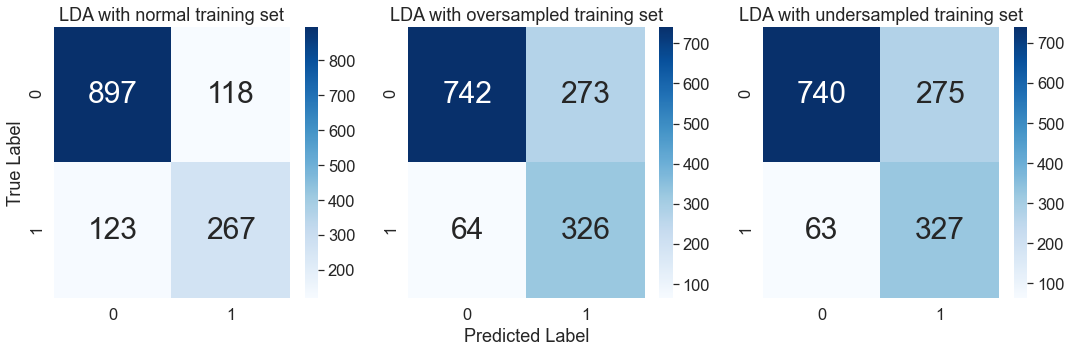

In [156]:
# Normal
lda = LinearDiscriminantAnalysis().fit(X_train_mds, y_train)
print(lda.score(X_test_mds, y_test))

lda_pred = lda.predict(X_test_mds)
#print(classification_report(y_test, lda_pred))
print(cohen_kappa_score(y_test, lda_pred))
print(classification_report(y_test, lda_pred))

# Over-under sampling
lda_over = LinearDiscriminantAnalysis().fit(X_mds_over, y_over)
lda_under = LinearDiscriminantAnalysis().fit(X_mds_under, y_under)

print(lda_over.score(X_test_mds, y_test))
print(lda_under.score(X_test_mds, y_test))

lda_over_pred = lda_over.predict(X_test_mds)
print(classification_report(y_test, lda_over_pred))

lda_under_pred = lda_under.predict(X_test_mds)
print(classification_report(y_test, knn_under_pred))

print(cohen_kappa_score(y_test, lda_over_pred))
print(cohen_kappa_score(y_test, lda_under_pred))

#generating confusion matrix
plt.rcParams["figure.figsize"] = (18, 5)
plt.subplot(131)
sns.heatmap(confusion_matrix(y_test, lda_pred), annot=True, cmap='Blues', fmt='g')
plt.ylabel("True Label")
plt.title('LDA with normal training set')
plt.subplot(132)
sns.heatmap(confusion_matrix(y_test, lda_over_pred), annot=True, cmap='Blues', fmt='g')

plt.xlabel("Predicted Label")
plt.title('LDA with oversampled training set')
plt.subplot(133)
sns.heatmap(confusion_matrix(y_test, lda_under_pred), annot=True, cmap='Blues', fmt='g')
plt.title('LDA with undersampled training set')


plt.savefig('lda_conf_matixMDS.pdf')
plt.show()
plt.rcParams["figure.figsize"] = (15, 10)


0.8163701067615659
0.5581814857700043
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1015
           1       0.65      0.73      0.69       390

    accuracy                           0.82      1405
   macro avg       0.77      0.79      0.78      1405
weighted avg       0.82      0.82      0.82      1405

0.7451957295373666
0.7451957295373666
              precision    recall  f1-score   support

           0       0.92      0.71      0.80      1015
           1       0.53      0.84      0.65       390

    accuracy                           0.75      1405
   macro avg       0.72      0.77      0.72      1405
weighted avg       0.81      0.75      0.76      1405

              precision    recall  f1-score   support

           0       0.92      0.71      0.80      1015
           1       0.53      0.84      0.65       390

    accuracy                           0.75      1405
   macro avg       0.72      0.77      0.72      140

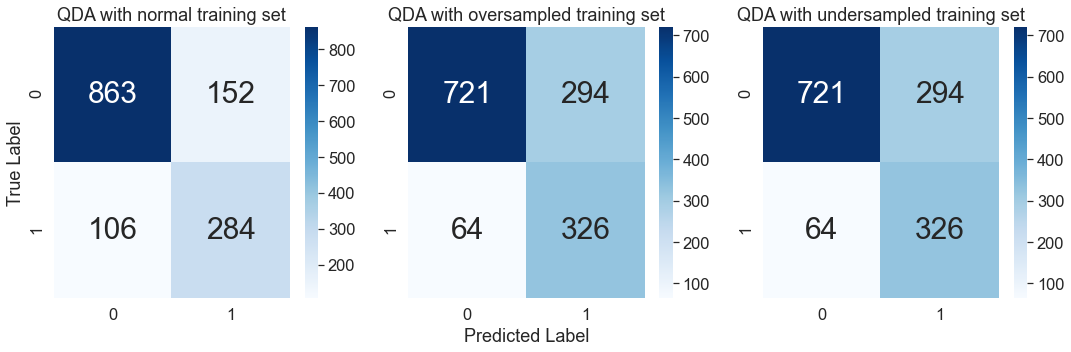

In [157]:
# Normal
qda = QuadraticDiscriminantAnalysis().fit(X_train_mds, y_train)
print(qda.score(X_test_mds, y_test))

qda_pred = qda.predict(X_test_mds)
#print(classification_report(y_test, lda_pred))
print(cohen_kappa_score(y_test, qda_pred))
print(classification_report(y_test, qda_pred))

# Over-under sampling
qda_over = QuadraticDiscriminantAnalysis().fit(X_mds_over, y_over)
qda_under = QuadraticDiscriminantAnalysis().fit(X_mds_under, y_under)

print(qda_over.score(X_test_mds, y_test))

print(qda_under.score(X_test_mds, y_test))


qda_over_pred = qda_over.predict(X_test_mds)
print(classification_report(y_test, qda_over_pred))
qda_under_pred = qda_under.predict(X_test_mds)
print(classification_report(y_test, qda_under_pred))
print(cohen_kappa_score(y_test, qda_over_pred))
print(cohen_kappa_score(y_test, qda_under_pred))

#generating confusion matrix
plt.rcParams["figure.figsize"] = (18, 5)
plt.subplot(131)
sns.heatmap(confusion_matrix(y_test, qda_pred), annot=True, cmap='Blues', fmt='g')
plt.ylabel("True Label")
plt.title('QDA with normal training set')
plt.subplot(132)
sns.heatmap(confusion_matrix(y_test, qda_over_pred), annot=True, cmap='Blues', fmt='g')

plt.xlabel("Predicted Label")
plt.title('QDA with oversampled training set')
plt.subplot(133)
sns.heatmap(confusion_matrix(y_test, qda_under_pred), annot=True, cmap='Blues', fmt='g')
plt.title('QDA with undersampled training set')


plt.savefig('qda_conf_matixMDS.pdf')
plt.show()
plt.rcParams["figure.figsize"] = (15, 10)


## 3. Decision tree

In [158]:
from sklearn.tree import DecisionTreeClassifier

### 3.1 PCA


0.7338078291814947
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1015
           1       0.52      0.49      0.50       390

    accuracy                           0.73      1405
   macro avg       0.66      0.66      0.66      1405
weighted avg       0.73      0.73      0.73      1405

0.3223676574891998
0.7359430604982207
              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1015
           1       0.53      0.51      0.52       390

    accuracy                           0.74      1405
   macro avg       0.67      0.67      0.67      1405
weighted avg       0.73      0.74      0.73      1405

0.3347733146157037


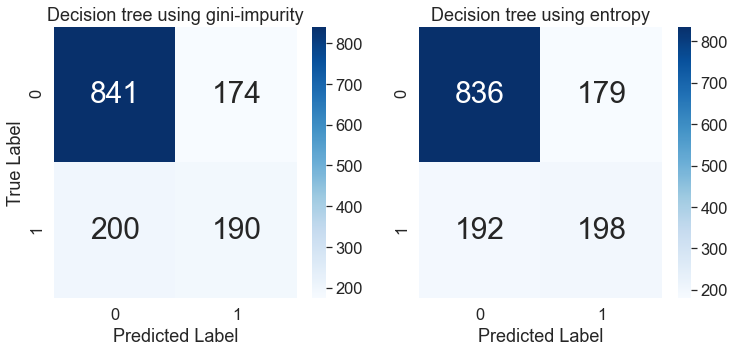

In [251]:
tree = DecisionTreeClassifier().fit(X_train_pca, y_train)
print(tree.score(X_test_pca, y_test))
tree_pred = tree.predict(X_test_pca)
print(classification_report(y_test, tree_pred))
print(cohen_kappa_score(y_test, tree_pred))

tree_e = DecisionTreeClassifier(criterion='entropy').fit(X_train_pca, y_train)
print(tree_e.score(X_test_pca, y_test))
tree_pred_e = tree_e.predict(X_test_pca)
print(classification_report(y_test, tree_pred_e))
print(cohen_kappa_score(y_test, tree_pred_e))


#generating confusion matrix
plt.rcParams["figure.figsize"] = (12, 5)
plt.subplot(121)
sns.heatmap(confusion_matrix(y_test, tree_pred), annot=True, cmap='Blues', fmt='g')
plt.ylabel("True Label")
plt.title('Decision tree using gini-impurity')
plt.xlabel("Predicted Label")
plt.subplot(122)
sns.heatmap(confusion_matrix(y_test, tree_pred_e), annot=True, cmap='Blues', fmt='g')

plt.xlabel("Predicted Label")
plt.title('Decision tree using entropy')


plt.savefig('tree_gini_e_conf_matixPCA.pdf')
plt.show()
plt.rcParams["figure.figsize"] = (15, 10)


0.7359430604982207
0.6768683274021352
0.332644112281151
0.2945476664454767


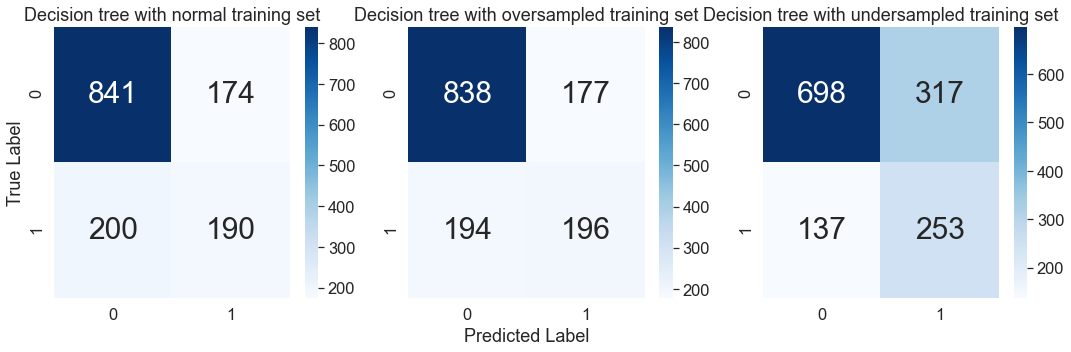

In [252]:
# Over-under sampling
tree_over = DecisionTreeClassifier().fit(X_pca_over, y_over)
tree_under = DecisionTreeClassifier().fit(X_pca_under, y_under)

print(tree_over.score(X_test_pca, y_test))
print(tree_under.score(X_test_pca, y_test))

tree_over_pred = tree_over.predict(X_test_pca)
tree_under_pred = tree_under.predict(X_test_pca)

print(cohen_kappa_score(y_test, tree_over_pred))
print(cohen_kappa_score(y_test, tree_under_pred))

#generating confusion matrix
plt.rcParams["figure.figsize"] = (18, 5)
plt.subplot(131)
sns.heatmap(confusion_matrix(y_test, tree_pred), annot=True, cmap='Blues', fmt='g')
plt.ylabel("True Label")
plt.title('Decision tree with normal training set')
plt.subplot(132)
sns.heatmap(confusion_matrix(y_test, tree_over_pred), annot=True, cmap='Blues', fmt='g')

plt.xlabel("Predicted Label")
plt.title('Decision tree with oversampled training set')
plt.subplot(133)
sns.heatmap(confusion_matrix(y_test, tree_under_pred), annot=True, cmap='Blues', fmt='g')
plt.title('Decision tree with undersampled training set')


plt.savefig('tree_conf_matixPCA.pdf')
plt.show()
plt.rcParams["figure.figsize"] = (15, 10)

0.7373665480427046
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1015
           1       0.53      0.50      0.51       390

    accuracy                           0.74      1405
   macro avg       0.67      0.66      0.67      1405
weighted avg       0.73      0.74      0.74      1405

0.33411039398901843
0.7302491103202847
0.699644128113879
0.316064605208233
0.34517643160859235


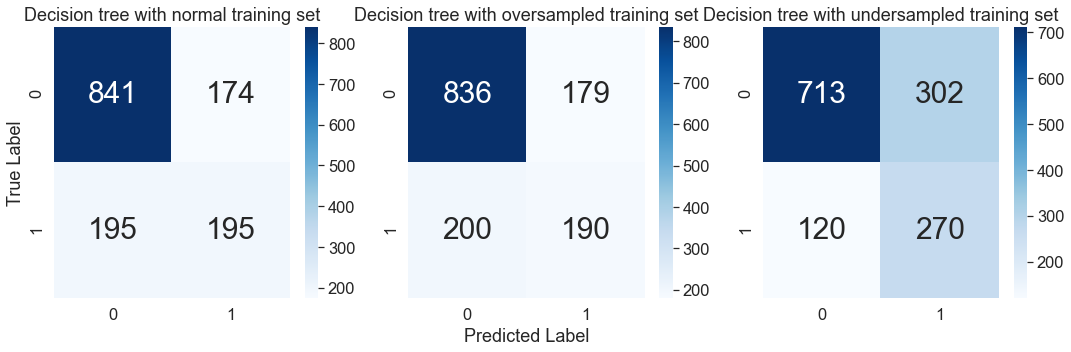

In [253]:
tree = DecisionTreeClassifier(criterion='entropy').fit(X_train_pca, y_train)
print(tree.score(X_test_pca, y_test))
tree_pred = tree.predict(X_test_pca)
print(classification_report(y_test, tree_pred))
print(cohen_kappa_score(y_test, tree_pred))

# Over-under sampling
tree_over = DecisionTreeClassifier(criterion='entropy').fit(X_pca_over, y_over)
tree_under = DecisionTreeClassifier(criterion='entropy').fit(X_pca_under, y_under)

print(tree_over.score(X_test_pca, y_test))
print(tree_under.score(X_test_pca, y_test))

tree_over_pred = tree_over.predict(X_test_pca)
tree_under_pred = tree_under.predict(X_test_pca)

print(cohen_kappa_score(y_test, tree_over_pred))
print(cohen_kappa_score(y_test, tree_under_pred))

#generating confusion matrix
plt.rcParams["figure.figsize"] = (18, 5)
plt.subplot(131)
sns.heatmap(confusion_matrix(y_test, tree_pred), annot=True, cmap='Blues', fmt='g')
plt.ylabel("True Label")
plt.title('Decision tree with normal training set')
plt.subplot(132)
sns.heatmap(confusion_matrix(y_test, tree_over_pred), annot=True, cmap='Blues', fmt='g')

plt.xlabel("Predicted Label")
plt.title('Decision tree with oversampled training set')
plt.subplot(133)
sns.heatmap(confusion_matrix(y_test, tree_under_pred), annot=True, cmap='Blues', fmt='g')
plt.title('Decision tree with undersampled training set')


plt.savefig('tree_conf_matix_entrophy_PCA.pdf')
plt.show()
plt.rcParams["figure.figsize"] = (15, 10)


### 3.2 MDS


0.8790035587188612
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1015
           1       0.81      0.74      0.77       390

    accuracy                           0.88      1405
   macro avg       0.85      0.84      0.85      1405
weighted avg       0.88      0.88      0.88      1405

0.6909890678569119
0.8854092526690391
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1015
           1       0.82      0.75      0.79       390

    accuracy                           0.89      1405
   macro avg       0.86      0.84      0.85      1405
weighted avg       0.88      0.89      0.88      1405

0.7071116434143656


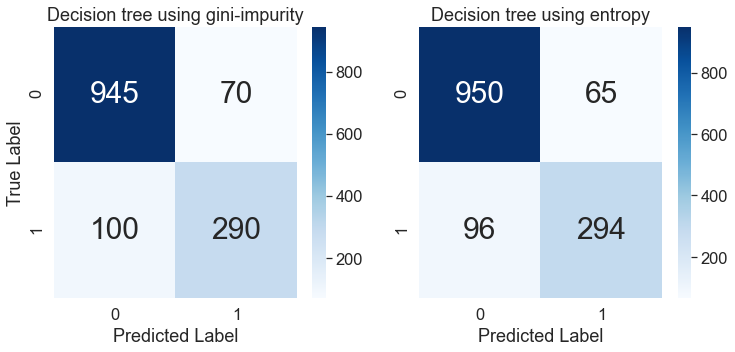

In [162]:
tree = DecisionTreeClassifier().fit(X_train_mds, y_train)
print(tree.score(X_test_mds, y_test))
tree_pred = tree.predict(X_test_mds)
print(classification_report(y_test, tree_pred))
print(cohen_kappa_score(y_test, tree_pred))

tree_e = DecisionTreeClassifier(criterion='entropy').fit(X_train_mds, y_train)
print(tree_e.score(X_test_mds, y_test))
tree_pred_e = tree_e.predict(X_test_mds)
print(classification_report(y_test, tree_pred_e))
print(cohen_kappa_score(y_test, tree_pred_e))


#generating confusion matrix
plt.rcParams["figure.figsize"] = (12, 5)
plt.subplot(121)
sns.heatmap(confusion_matrix(y_test, tree_pred), annot=True, cmap='Blues', fmt='g')
plt.ylabel("True Label")
plt.title('Decision tree using gini-impurity')
plt.xlabel("Predicted Label")
plt.subplot(122)
sns.heatmap(confusion_matrix(y_test, tree_pred_e), annot=True, cmap='Blues', fmt='g')

plt.xlabel("Predicted Label")
plt.title('Decision tree using entropy')


plt.savefig('tree_gini_e_conf_matixMDS.pdf')
plt.show()
plt.rcParams["figure.figsize"] = (15, 10)


0.8854092526690391
0.8583629893238434
0.7085268820668105
0.6675742353535654


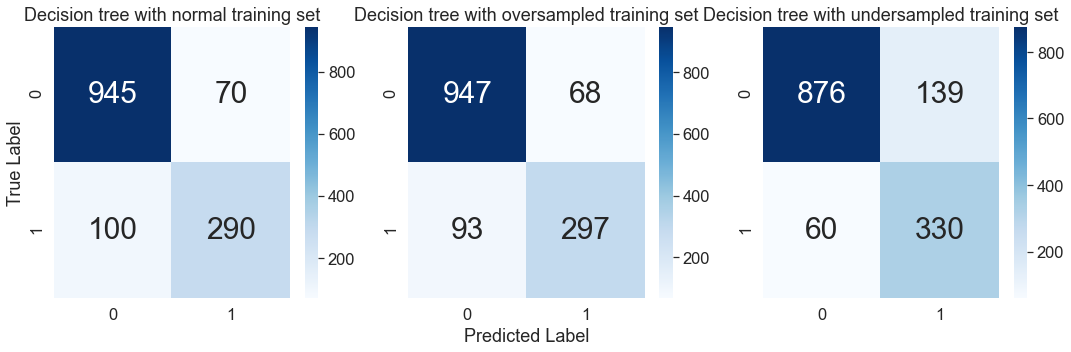

In [163]:
# Over-under sampling
tree_over = DecisionTreeClassifier().fit(X_mds_over, y_over)
tree_under = DecisionTreeClassifier().fit(X_mds_under, y_under)

print(tree_over.score(X_test_mds, y_test))
print(tree_under.score(X_test_mds, y_test))

tree_over_pred = tree_over.predict(X_test_mds)
tree_under_pred = tree_under.predict(X_test_mds)

print(cohen_kappa_score(y_test, tree_over_pred))
print(cohen_kappa_score(y_test, tree_under_pred))

#generating confusion matrix
plt.rcParams["figure.figsize"] = (18, 5)
plt.subplot(131)
sns.heatmap(confusion_matrix(y_test, tree_pred), annot=True, cmap='Blues', fmt='g')
plt.ylabel("True Label")
plt.title('Decision tree with normal training set')
plt.subplot(132)
sns.heatmap(confusion_matrix(y_test, tree_over_pred), annot=True, cmap='Blues', fmt='g')

plt.xlabel("Predicted Label")
plt.title('Decision tree with oversampled training set')
plt.subplot(133)
sns.heatmap(confusion_matrix(y_test, tree_under_pred), annot=True, cmap='Blues', fmt='g')
plt.title('Decision tree with undersampled training set')


plt.savefig('tree_conf_matixMDS.pdf')
plt.show()
plt.rcParams["figure.figsize"] = (15, 10)

0.8918149466192171
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      1015
           1       0.83      0.76      0.80       390

    accuracy                           0.89      1405
   macro avg       0.87      0.85      0.86      1405
weighted avg       0.89      0.89      0.89      1405

0.7232603343268109
0.8875444839857651
0.8512455516014235
0.7146474709171541
0.6524191400585919


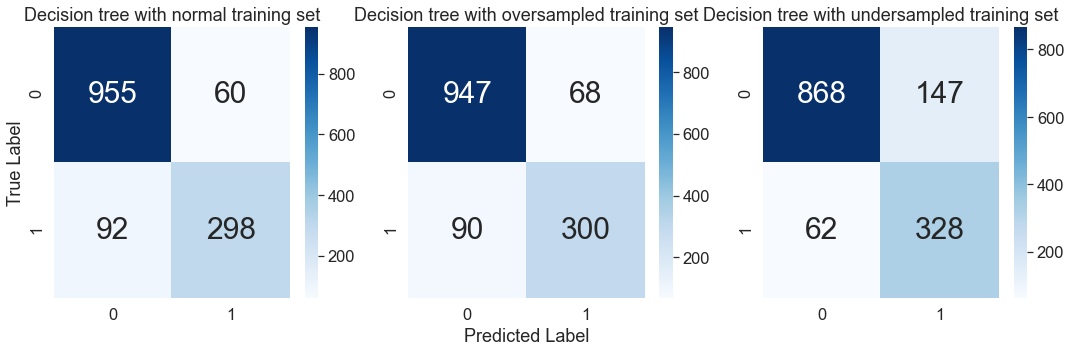

In [164]:
tree = DecisionTreeClassifier(criterion='entropy').fit(X_train_mds, y_train)
print(tree.score(X_test_mds, y_test))
tree_pred = tree.predict(X_test_mds)
print(classification_report(y_test, tree_pred))
print(cohen_kappa_score(y_test, tree_pred))

# Over-under sampling
tree_over = DecisionTreeClassifier(criterion='entropy').fit(X_mds_over, y_over)
tree_under = DecisionTreeClassifier(criterion='entropy').fit(X_mds_under, y_under)

print(tree_over.score(X_test_mds, y_test))
print(tree_under.score(X_test_mds, y_test))

tree_over_pred = tree_over.predict(X_test_mds)
tree_under_pred = tree_under.predict(X_test_mds)

print(cohen_kappa_score(y_test, tree_over_pred))
print(cohen_kappa_score(y_test, tree_under_pred))

#generating confusion matrix
plt.rcParams["figure.figsize"] = (18, 5)
plt.subplot(131)
sns.heatmap(confusion_matrix(y_test, tree_pred), annot=True, cmap='Blues', fmt='g')
plt.ylabel("True Label")
plt.title('Decision tree with normal training set')
plt.subplot(132)
sns.heatmap(confusion_matrix(y_test, tree_over_pred), annot=True, cmap='Blues', fmt='g')

plt.xlabel("Predicted Label")
plt.title('Decision tree with oversampled training set')
plt.subplot(133)
sns.heatmap(confusion_matrix(y_test, tree_under_pred), annot=True, cmap='Blues', fmt='g')
plt.title('Decision tree with undersampled training set')


plt.savefig('tree_conf_matix_entrophy_MDS.pdf')
plt.show()
plt.rcParams["figure.figsize"] = (15, 10)


## 4.  Random forest

In [165]:
from sklearn.ensemble import RandomForestClassifier

### 4.1 PCA


0.7786476868327402
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1015
           1       0.63      0.49      0.55       390

    accuracy                           0.78      1405
   macro avg       0.73      0.69      0.70      1405
weighted avg       0.77      0.78      0.77      1405

[[904 111]
 [200 190]]
kappa: 0.4063716333254084
ENTROPHY:
0.7750889679715303
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1015
           1       0.63      0.47      0.54       390

    accuracy                           0.78      1405
   macro avg       0.72      0.68      0.69      1405
weighted avg       0.76      0.78      0.76      1405

[[905 110]
 [206 184]]
kappa: 0.3932212655459888


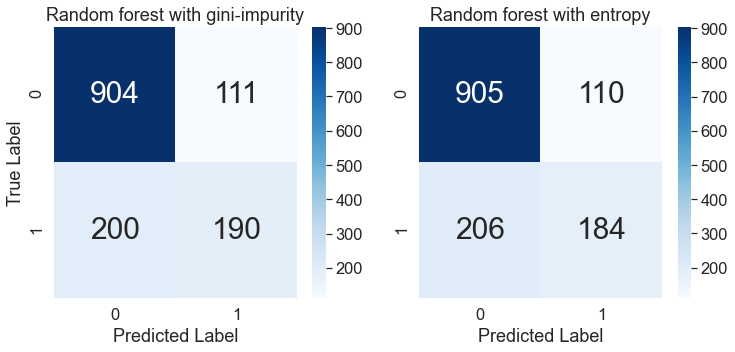

In [254]:
RandomForest = RandomForestClassifier(criterion='gini').fit(X_train_pca, y_train)
# print(RandomForest.score(X_test, y_test))

print(RandomForest.score(X_test_pca, y_test))
Gini_predict = RandomForest.predict(X_test_pca)
print(classification_report(y_test, Gini_predict))
print(confusion_matrix(y_test, Gini_predict))
print('kappa:', cohen_kappa_score(y_test, Gini_predict))

print('ENTROPHY:')
RandomForestEntropy = RandomForestClassifier(criterion='entropy').fit(X_train_pca, y_train)

print(RandomForestEntropy.score(X_test_pca, y_test))
Entropy_predict = RandomForestEntropy.predict(X_test_pca)
print(classification_report(y_test, Entropy_predict))
print(confusion_matrix(y_test, Entropy_predict))
print('kappa:', cohen_kappa_score(y_test, Entropy_predict))

#generating confusion matrix
plt.rcParams["figure.figsize"] = (12, 5)
plt.subplot(121)
sns.heatmap(confusion_matrix(y_test, Gini_predict), annot=True, cmap='Blues', fmt='g')
plt.ylabel("True Label")
plt.title('Random forest with gini-impurity')
plt.xlabel("Predicted Label")
plt.subplot(122)
sns.heatmap(confusion_matrix(y_test, Entropy_predict), annot=True, cmap='Blues', fmt='g')

plt.xlabel("Predicted Label")
plt.title('Random forest with entropy')


plt.savefig('forest_gini_e_conf_matixPCA.pdf')
plt.show()
plt.rcParams["figure.figsize"] = (15, 10)


Acc - Gini
0.7274021352313167
0.6846975088967971
0.31105847709887013
0.3140109663020417
Acc - Entropy
0.7252669039145907
0.693950177935943
0.3106266683615101
0.33091533307492116


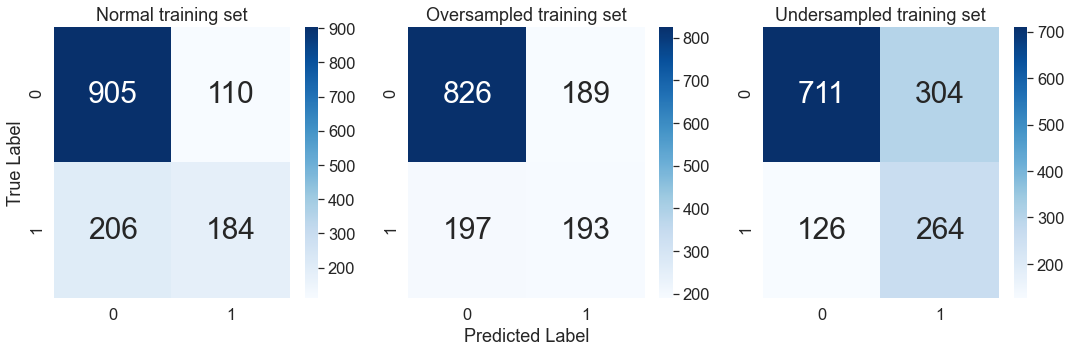

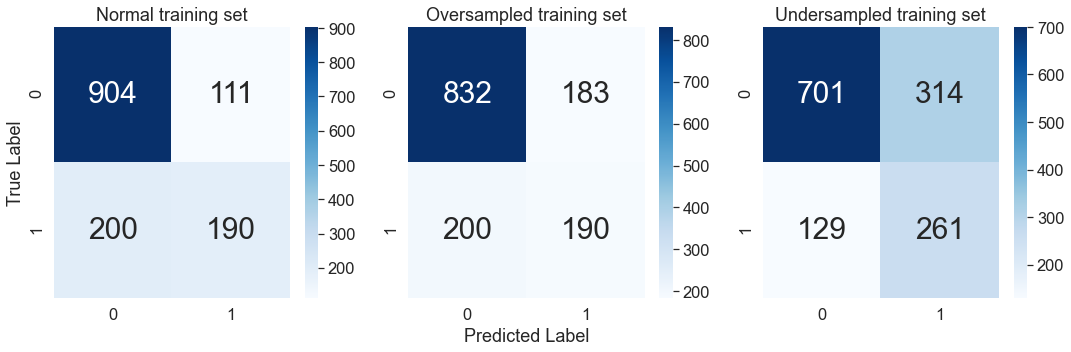

In [255]:
# Over-under sampling 
# Gini
forest_over = DecisionTreeClassifier().fit(X_pca_over, y_over)
forest_under = DecisionTreeClassifier().fit(X_pca_under, y_under)

print('Acc - Gini')
print(forest_over.score(X_test_pca, y_test))
print(forest_under.score(X_test_pca, y_test))

forest_over_pred = forest_over.predict(X_test_pca)
forest_under_pred = forest_under.predict(X_test_pca)

print(cohen_kappa_score(y_test, forest_over_pred))
print(cohen_kappa_score(y_test, forest_under_pred))

# entropy
forest_over_e = DecisionTreeClassifier(criterion='entropy').fit(X_pca_over, y_over)
forest_under_e = DecisionTreeClassifier(criterion='entropy').fit(X_pca_under, y_under)

print('Acc - Entropy')
print(forest_over_e.score(X_test_pca, y_test))
print(forest_under_e.score(X_test_pca, y_test))

forest_over_pred_e = forest_over_e.predict(X_test_pca)
forest_under_pred_e = forest_under_e.predict(X_test_pca)

print(cohen_kappa_score(y_test, forest_over_pred_e))
print(cohen_kappa_score(y_test, forest_under_pred_e))



#generating confusion matrix
plt.rcParams["figure.figsize"] = (18, 5)
plt.subplot(131)
sns.heatmap(confusion_matrix(y_test, Entropy_predict), annot=True, cmap='Blues', fmt='g')
plt.ylabel("True Label")
plt.title('Normal training set')
plt.subplot(132)
sns.heatmap(confusion_matrix(y_test, forest_over_pred_e), annot=True, cmap='Blues', fmt='g')

plt.xlabel("Predicted Label")
plt.title('Oversampled training set')
plt.subplot(133)
sns.heatmap(confusion_matrix(y_test, forest_under_pred_e), annot=True, cmap='Blues', fmt='g')
plt.title('Undersampled training set')


plt.savefig('forest_conf_matixPCA.pdf')
plt.show()
plt.rcParams["figure.figsize"] = (15, 10)


#generating confusion matrix
plt.rcParams["figure.figsize"] = (18, 5)
plt.subplot(131)
sns.heatmap(confusion_matrix(y_test, Gini_predict), annot=True, cmap='Blues', fmt='g')
plt.ylabel("True Label")
plt.title('Normal training set')
plt.subplot(132)
sns.heatmap(confusion_matrix(y_test, forest_over_pred), annot=True, cmap='Blues', fmt='g')

plt.xlabel("Predicted Label")
plt.title('Oversampled training set')
plt.subplot(133)
sns.heatmap(confusion_matrix(y_test, forest_under_pred), annot=True, cmap='Blues', fmt='g')
plt.title('Undersampled training set')


plt.savefig('gini_forest_conf_matixPCA.pdf')
plt.show()
plt.rcParams["figure.figsize"] = (15, 10)

### 4.2 MDS


0.9117437722419929
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1015
           1       0.90      0.77      0.83       390

    accuracy                           0.91      1405
   macro avg       0.91      0.87      0.88      1405
weighted avg       0.91      0.91      0.91      1405

[[982  33]
 [ 91 299]]
kappa: 0.7693824872592494
ENTROPHY:
0.9074733096085409
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1015
           1       0.90      0.75      0.82       390

    accuracy                           0.91      1405
   macro avg       0.90      0.86      0.88      1405
weighted avg       0.91      0.91      0.90      1405

[[982  33]
 [ 97 293]]
kappa: 0.7570174271650925


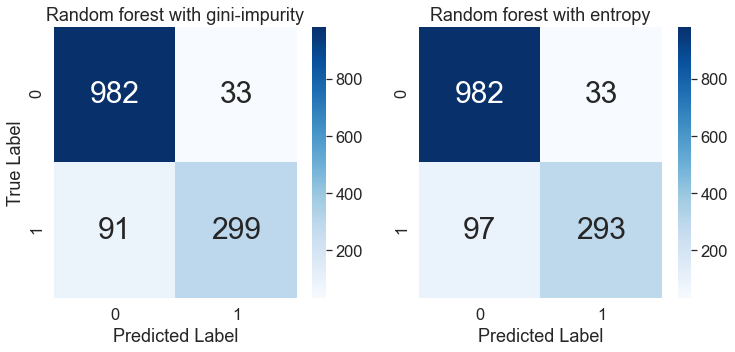

In [170]:
RandomForest = RandomForestClassifier(criterion='gini').fit(X_train_mds, y_train)
# print(RandomForest.score(X_test, y_test))

print(RandomForest.score(X_test_mds, y_test))
Gini_predict = RandomForest.predict(X_test_mds)
print(classification_report(y_test, Gini_predict))
print(confusion_matrix(y_test, Gini_predict))
print('kappa:', cohen_kappa_score(y_test, Gini_predict))

print('ENTROPHY:')
RandomForestEntropy = RandomForestClassifier(criterion='entropy').fit(X_train_mds, y_train)

print(RandomForestEntropy.score(X_test_mds, y_test))
Entropy_predict = RandomForestEntropy.predict(X_test_mds)
print(classification_report(y_test, Entropy_predict))
print(confusion_matrix(y_test, Entropy_predict))
print('kappa:', cohen_kappa_score(y_test, Entropy_predict))

#generating confusion matrix
plt.rcParams["figure.figsize"] = (12, 5)
plt.subplot(121)
sns.heatmap(confusion_matrix(y_test, Gini_predict), annot=True, cmap='Blues', fmt='g')
plt.ylabel("True Label")
plt.title('Random forest with gini-impurity')
plt.xlabel("Predicted Label")
plt.subplot(122)
sns.heatmap(confusion_matrix(y_test, Entropy_predict), annot=True, cmap='Blues', fmt='g')

plt.xlabel("Predicted Label")
plt.title('Random forest with entropy')


plt.savefig('forest_gini_e_conf_matixMDS.pdf')
plt.show()
plt.rcParams["figure.figsize"] = (15, 10)


Acc - Gini
0.8875444839857651
0.8491103202846975
0.7151052361396304
0.6476905789816074
Acc - Entropy
0.8846975088967971
0.8491103202846975
0.7069524913093859
0.6482107003661273


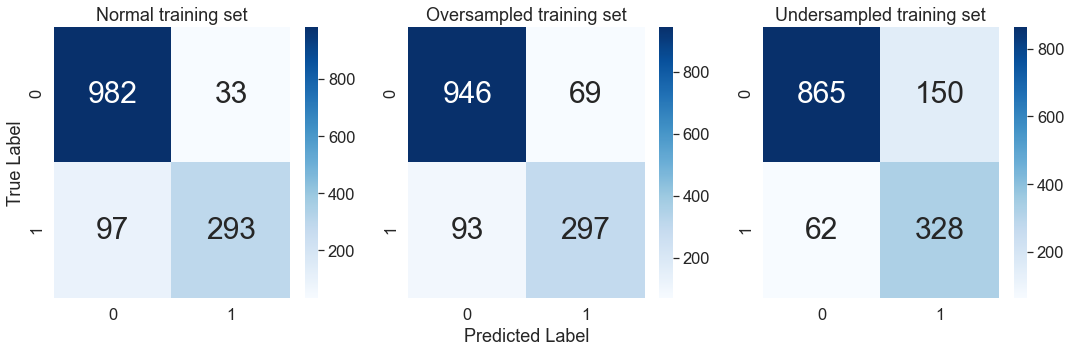

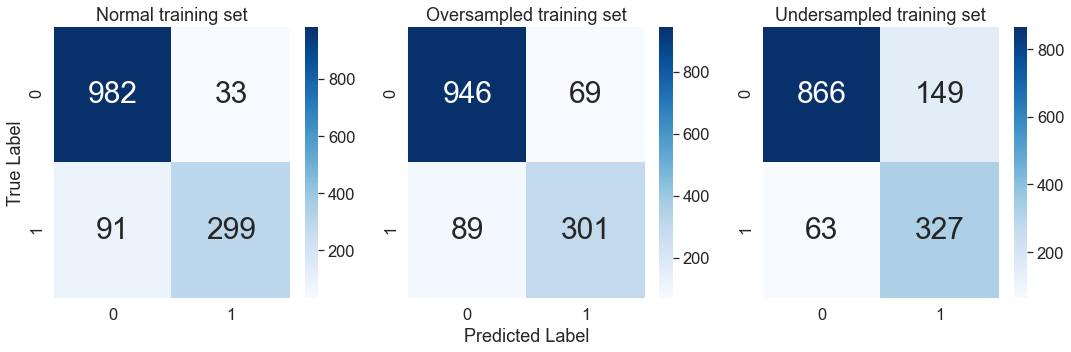

In [171]:
# Over-under sampling 
# Gini
forest_over = DecisionTreeClassifier().fit(X_mds_over, y_over)
forest_under = DecisionTreeClassifier().fit(X_mds_under, y_under)

print('Acc - Gini')
print(forest_over.score(X_test_mds, y_test))
print(forest_under.score(X_test_mds, y_test))

forest_over_pred = forest_over.predict(X_test_mds)
forest_under_pred = forest_under.predict(X_test_mds)

print(cohen_kappa_score(y_test, forest_over_pred))
print(cohen_kappa_score(y_test, forest_under_pred))

# entropy
forest_over_e = DecisionTreeClassifier(criterion='entropy').fit(X_mds_over, y_over)
forest_under_e = DecisionTreeClassifier(criterion='entropy').fit(X_mds_under, y_under)

print('Acc - Entropy')
print(forest_over_e.score(X_test_mds, y_test))
print(forest_under_e.score(X_test_mds, y_test))

forest_over_pred_e = forest_over_e.predict(X_test_mds)
forest_under_pred_e = forest_under_e.predict(X_test_mds)

print(cohen_kappa_score(y_test, forest_over_pred_e))
print(cohen_kappa_score(y_test, forest_under_pred_e))



#generating confusion matrix
plt.rcParams["figure.figsize"] = (18, 5)
plt.subplot(131)
sns.heatmap(confusion_matrix(y_test, Entropy_predict), annot=True, cmap='Blues', fmt='g')
plt.ylabel("True Label")
plt.title('Normal training set')
plt.subplot(132)
sns.heatmap(confusion_matrix(y_test, forest_over_pred_e), annot=True, cmap='Blues', fmt='g')

plt.xlabel("Predicted Label")
plt.title('Oversampled training set')
plt.subplot(133)
sns.heatmap(confusion_matrix(y_test, forest_under_pred_e), annot=True, cmap='Blues', fmt='g')
plt.title('Undersampled training set')


plt.savefig('forest_conf_matixMDS.pdf')
plt.show()
plt.rcParams["figure.figsize"] = (15, 10)


#generating confusion matrix
plt.rcParams["figure.figsize"] = (18, 5)
plt.subplot(131)
sns.heatmap(confusion_matrix(y_test, Gini_predict), annot=True, cmap='Blues', fmt='g')
plt.ylabel("True Label")
plt.title('Normal training set')
plt.subplot(132)
sns.heatmap(confusion_matrix(y_test, forest_over_pred), annot=True, cmap='Blues', fmt='g')

plt.xlabel("Predicted Label")
plt.title('Oversampled training set')
plt.subplot(133)
sns.heatmap(confusion_matrix(y_test, forest_under_pred), annot=True, cmap='Blues', fmt='g')
plt.title('Undersampled training set')


plt.savefig('gini_forest_conf_matixMDS.pdf')
plt.show()
plt.rcParams["figure.figsize"] = (15, 10)